# Neck link

This notebooks investigates all the possible causal paths between Sex, Height, BMI and Neck link ( or any possible Ansur antropometric variable). Ultimately the goal is to assess and estimated the causal effect of Sex, Height and BMI on antropometric measurements.

**How to compute neck Link**:

$$ Neck Link = Stature - Tragion top of head - Cervicale height $$ 

- *Stature*: the vertical distance from a standing surface to the top of the head.
- *Tragion top of the head*: The vertical distance between the right tragion landmark on the cartilaginous flap in front of the earhole and the horizontal plane tangent to the top of the head.
- *Cervicale height:* The vertical distance between a standing surface and the cervicale landmark at the base of the neck {cite:p}`gordon20142012`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import seaborn as sns
import networkx as nx
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("default")
plt.rcParams.update({'font.size': 12})

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


After reading the dataset from csv files: 
- The height given in millimeters is converted to centimeters.
- The weight is transformed into kilograms.
- BMI is computed based on the transformed height and weight values.
- The Gender column is converted into binary categorical variables. 1 represents Male, and 0 represents Female.

In [2]:
ansur_male = pd.read_csv("data/ANSUR2Distribution/Distribution/ANSUR II MALE Public.csv", encoding='latin-1') # 4082 samples
ansur_female = pd.read_csv("data/ANSUR2Distribution/Distribution/ANSUR II FEMALE Public.csv", encoding='latin-1') # 1986 samples
# Fix column name (hat tip: https://www.kaggle.com/seshadrikolluri/anthropometric-data-analysis-and-visualization)
ansur_female = ansur_female.rename(columns= {"SubjectId":"subjectid"}) 
# Combine the data and set the subjectid as index
ansur = pd.concat([ansur_male, ansur_female])
# Fix weight&stature column
ansur["stature"] = ansur["stature"]/10
ansur["weightkg"] = ansur["weightkg"]/10
ansur['necklink'] = (ansur.stature) - (ansur.tragiontopofhead/10) - (ansur.cervicaleheight/10) # neck length= stature - tragion'topofhead' - cervical height
ansur["BMI"] = ansur['weightkg'] / (ansur['stature']/100) **2
# Subset
columns = ['stature','BMI','necklink','Gender']
subset = ansur[columns].copy()
stats = subset.groupby("Gender")[["stature","BMI",'necklink']].describe()
subset['Gender'] = subset['Gender'].replace(['Male','Female'],['1','0']) # male and female with idicator variable 1== Male

In [3]:
ansur_link = subset.necklink
# height
height_std = subset.stature.std()
height_mean = subset.stature.mean()
ansur_height = subset.stature
# BMI
bmi_std = subset.BMI.std()
bmi_mean = subset.BMI.mean()
ansur_bmi = subset.BMI
s_index = subset["Gender"].astype(int).values

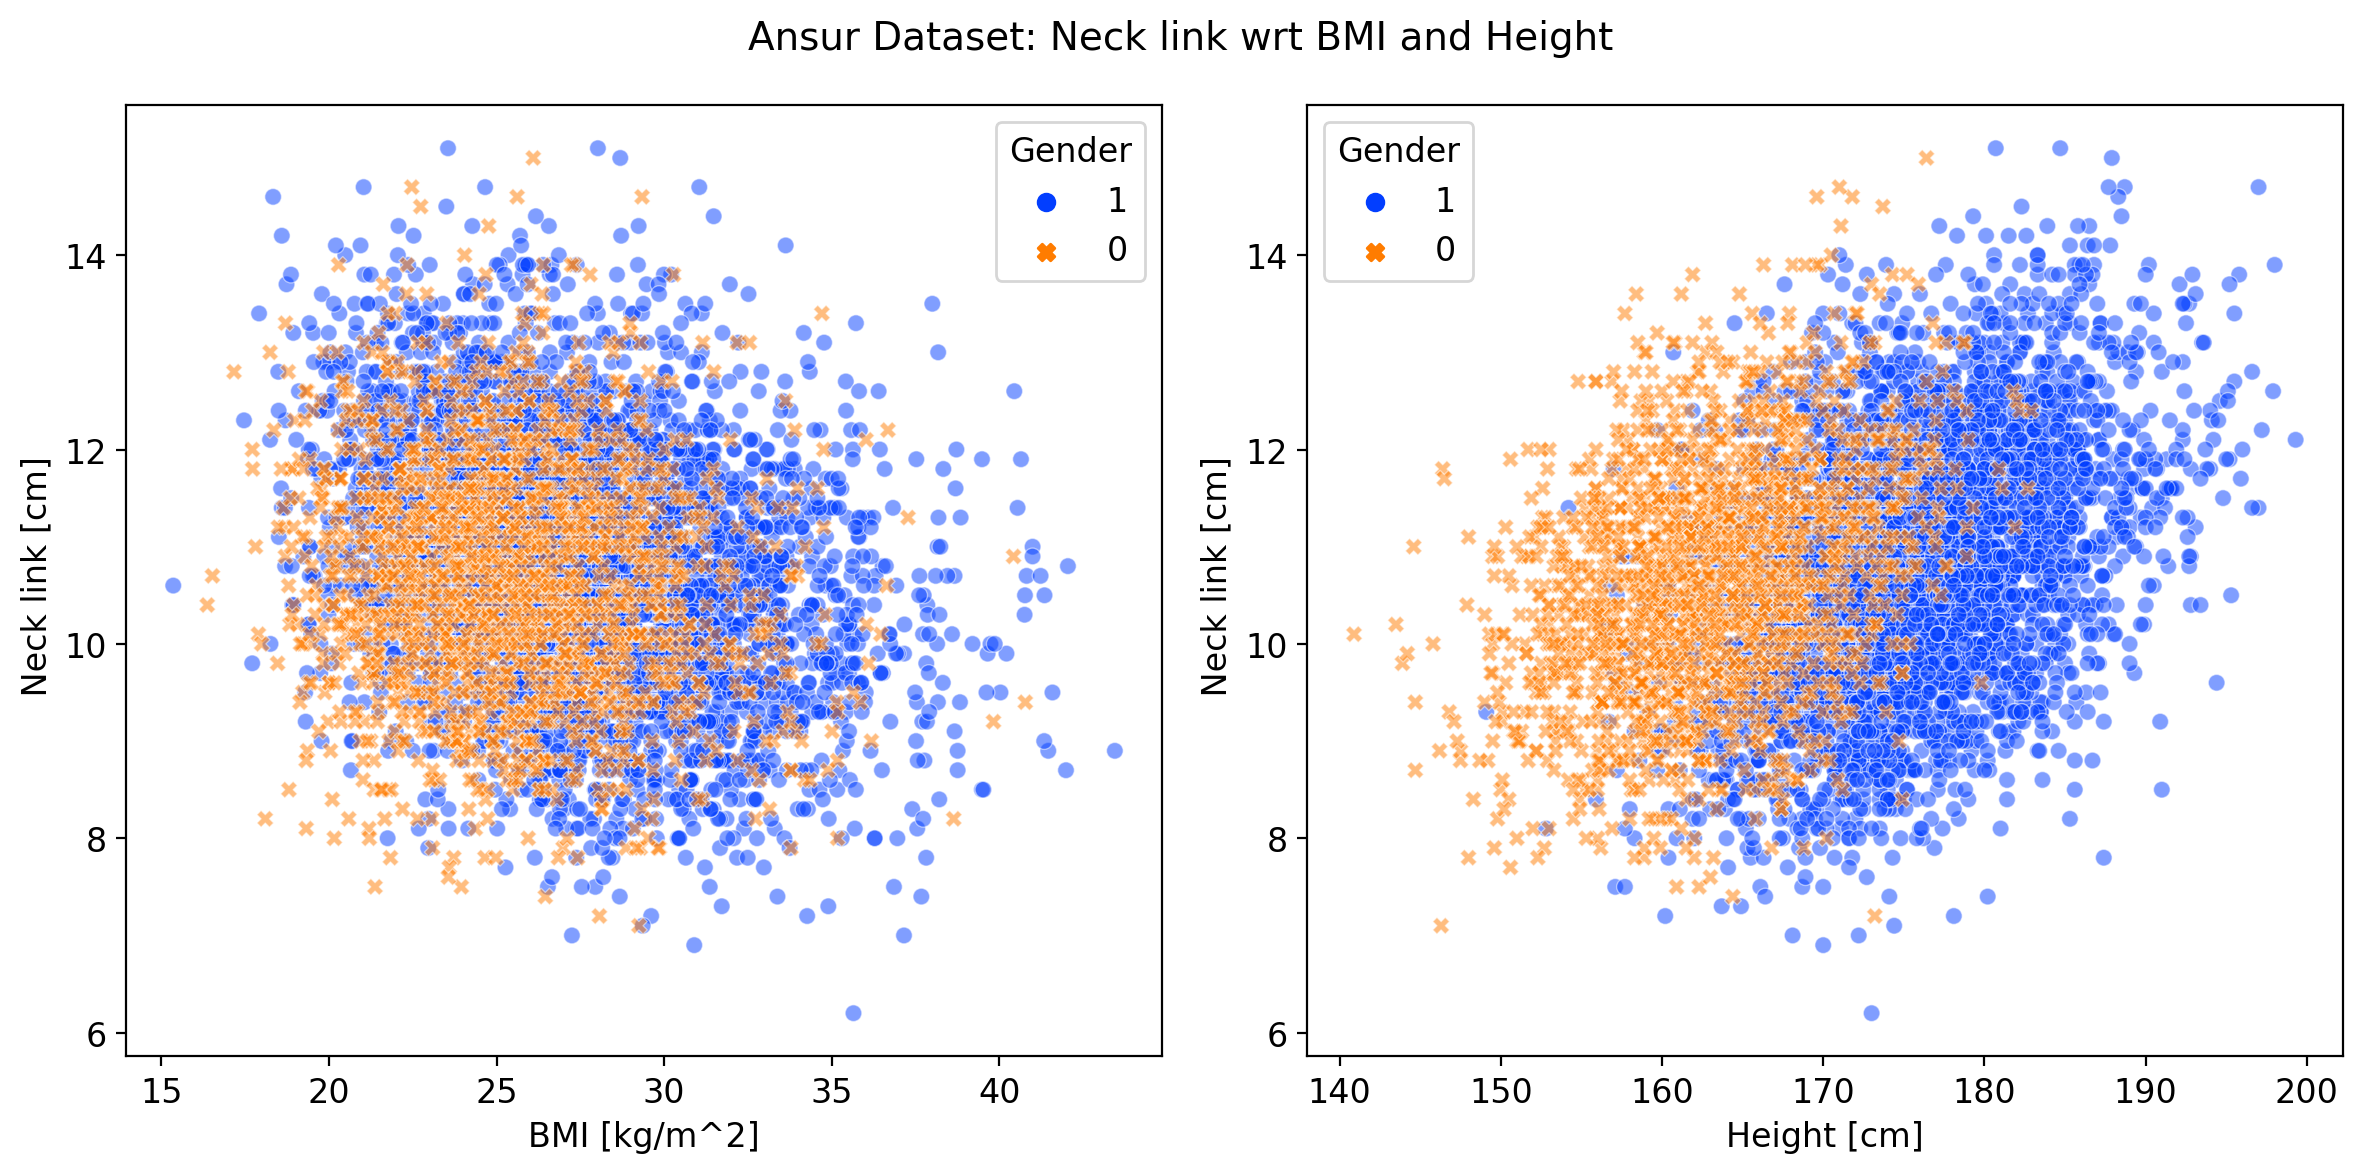

In [4]:
fig, axes = plt.subplots(1,2, figsize=(12, 6)) # male 1 and female 0
sns.scatterplot(ax = axes[0], data=subset,y="necklink", x="BMI", hue="Gender", style="Gender",palette="bright", alpha = 0.5)
sns.scatterplot(ax = axes[1], data=subset,y="necklink", x="stature", hue="Gender",style="Gender",palette="bright", alpha = 0.5)
axes[1].set_xlabel("Height [cm]");axes[1].set_ylabel(" Neck link [cm]")
axes[0].set_xlabel("BMI [kg/m^2]");axes[0].set_ylabel(" Neck link [cm]")
fig.suptitle("Ansur Dataset: Neck link wrt BMI and Height", fontsize = 14)
plt.tight_layout()

## The Model

Text(0.5, 0, '$x$')

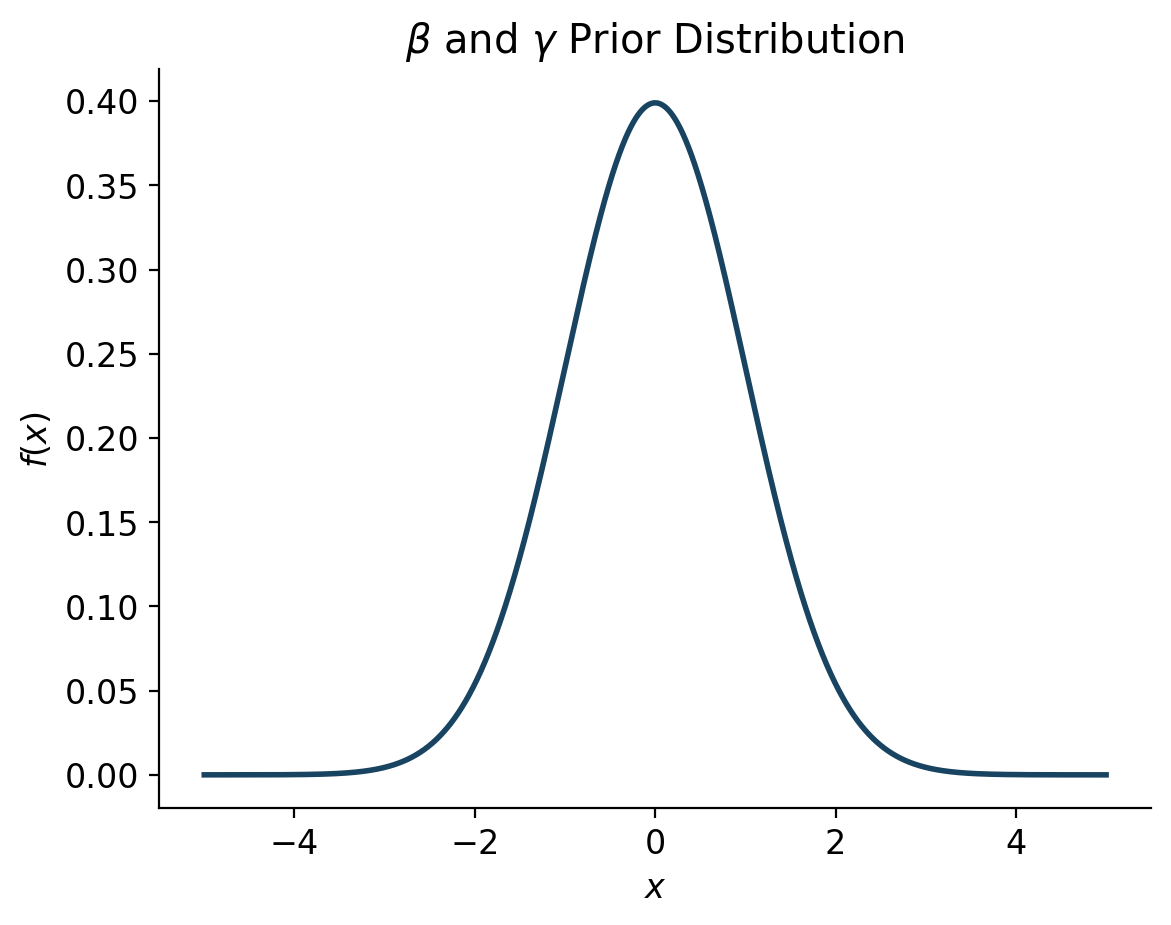

In [5]:
# Plot priors
# plot a normal distribution with mean 0 and standard deviation 1 
x = np.linspace(-5, 5, 10000)
y = norm.pdf(x, 0, 1)
plt.plot(x, y, color="#194461", linewidth=2)

# add a title ( alpha and beta ), axis title  showeing the mean and std in the plot
plt.title(r'$\beta$ and $\gamma $ Prior Distribution')

# hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# y axis is called f(x)
plt.ylabel(r'$f(x)$'); plt.xlabel(r'$x$')



(28.0, 40.0)

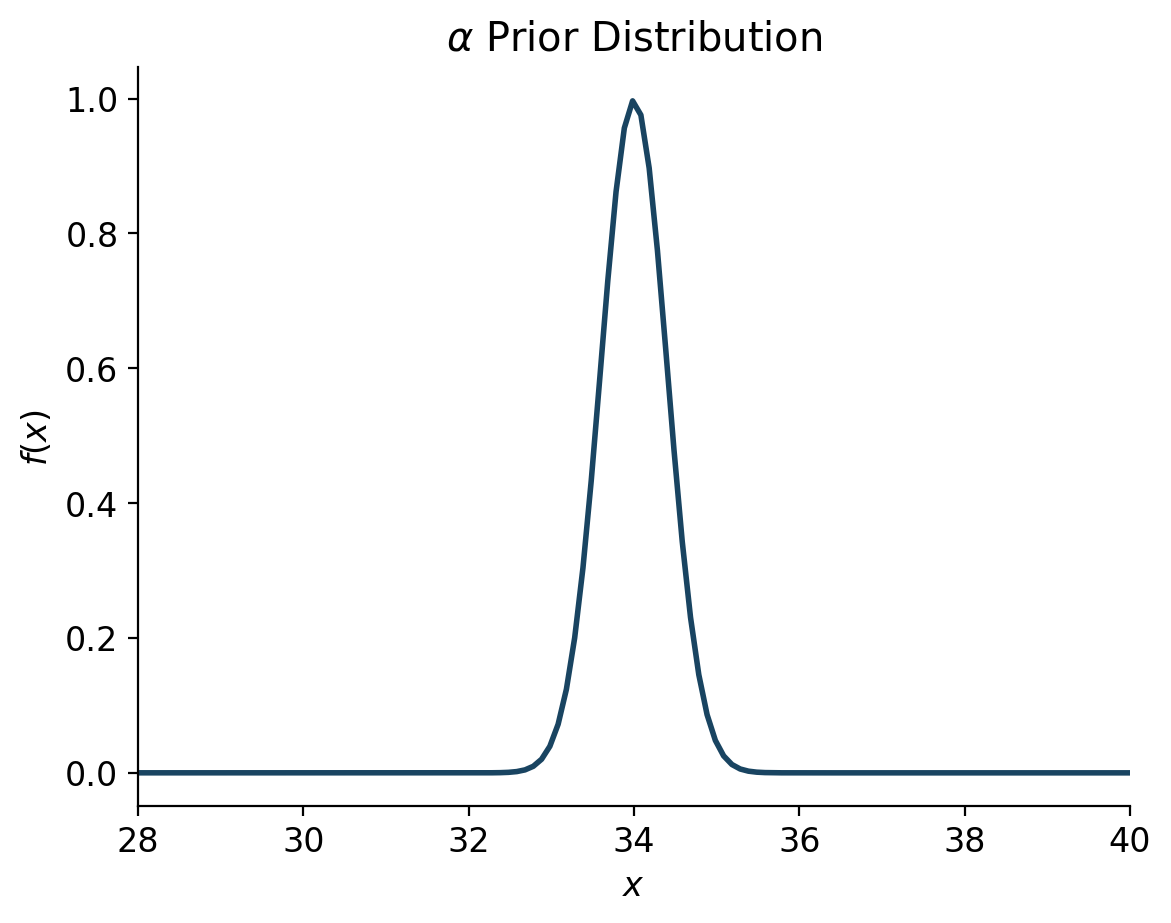

In [6]:
# plot a normal distribution with mean 35 and standard deviation 5 
import scipy.stats as st

x = np.linspace(-50,50, 1000)
mus = [34]
sigmas = [0.4]
for mu, sigma in zip(mus, sigmas):
    pdf = st.norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, color="#194461", linewidth=2)

# add a title ( alpha and beta ), axis title  showeing the mean and std in the plot
plt.title(r'$\alpha$ Prior Distribution')

# hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# y axis is called f(x)
plt.ylabel(r'$f(x)$')
plt.xlabel(r'$x$')
# set the x-axis limits between 0 and 50
plt.xlim(28, 40)

(-5.0, 5.0)

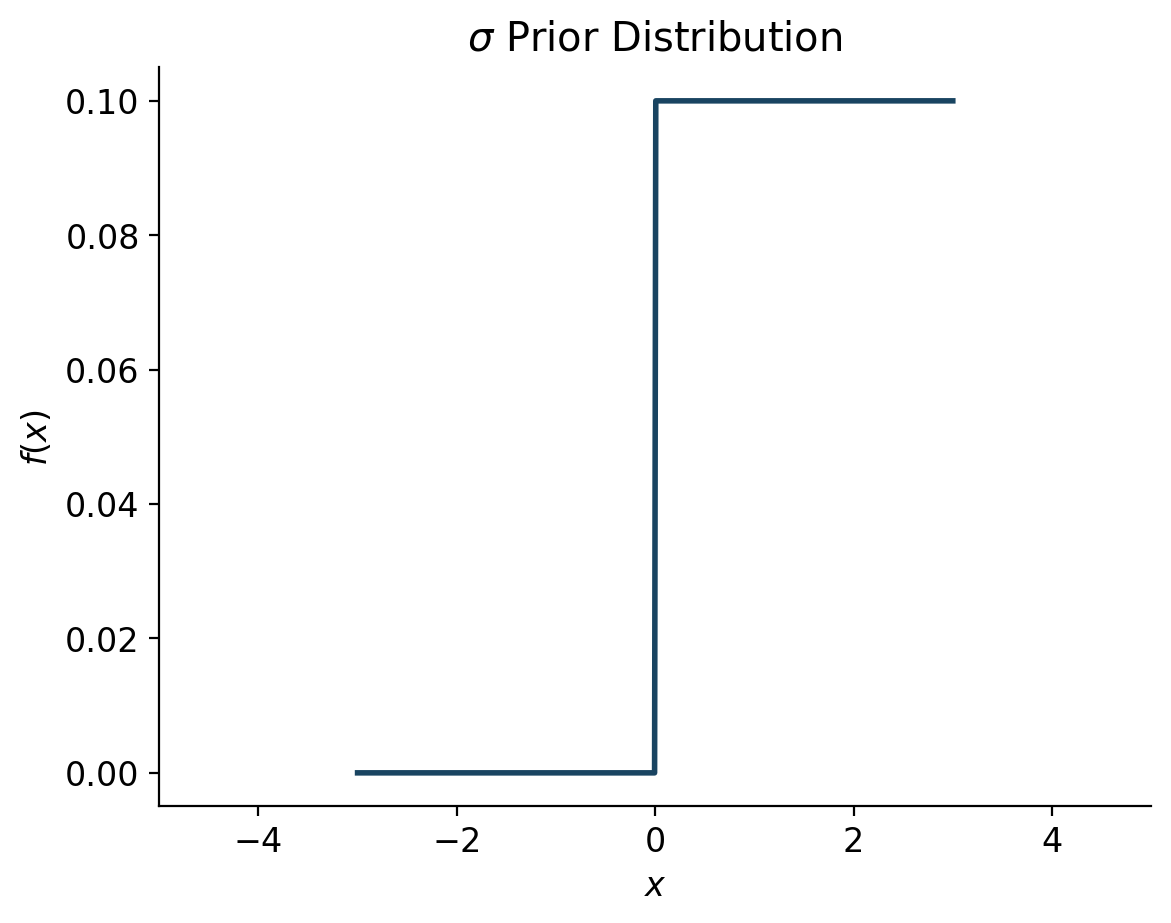

In [7]:
# plot a uniform distribution between 0 and 10

import scipy.stats as st

x = np.linspace(-3, 3, 500)
ls = [0.]
us = [10]
for l, u in zip(ls, us):
    y = np.zeros(500)
    y[(x<u) & (x>l)] = 1.0/(u-l)
    plt.plot(x, y, color="#194461", linewidth=2)

# add a title ( alpha and beta ), axis title  showeing the mean and std in the plot
plt.title(r'$\sigma$ Prior Distribution')

# hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# y axis is called f(x)
plt.ylabel(r'$f(x)$')
plt.xlabel(r'$x$')

plt.xlim(-5,5)

In [8]:
with pm.Model() as model:
    
    # Height & bmi 
    alpha = pm.Normal("alpha", 34,5,shape=2)
    beta = pm.Normal("beta", 0,1,shape=2)
    gamma = pm.Normal("gamma", 0,5,shape=2)
    sigma = pm.Uniform("sigma", 0,10)
    mu = pm.Deterministic("mu", alpha[s_index] + beta[s_index] * (ansur_height - height_mean) + gamma[s_index] * (ansur_bmi - bmi_mean))
    neck_link = pm.Normal("neck_link", mu, sigma, observed = ansur_link)  
    idata = pm.sample(draws=1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


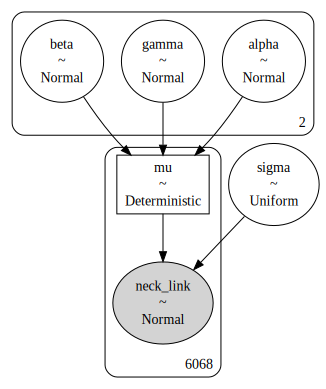

In [9]:
pm.model_to_graphviz(model)

In [10]:
az.summary(idata, var_names=["alpha", "beta", "gamma", "sigma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]  11.140  0.043  11.060   11.222      0.001      0.0    4099.0   
alpha[1]  10.536  0.020  10.499   10.574      0.000      0.0    5129.0   
beta[0]    0.067  0.004   0.059    0.074      0.000      0.0    3887.0   
beta[1]    0.074  0.002   0.069    0.078      0.000      0.0    4705.0   
gamma[0]  -0.045  0.007  -0.058   -0.031      0.000      0.0    6276.0   
gamma[1]  -0.093  0.004  -0.101   -0.086      0.000      0.0    5978.0   
sigma      1.100  0.010   1.083    1.119      0.000      0.0    6547.0   

          ess_tail  r_hat  
alpha[0]    3113.0    1.0  
alpha[1]    3348.0    1.0  
beta[0]     3067.0    1.0  
beta[1]     3377.0    1.0  
gamma[0]    2603.0    1.0  
gamma[1]    2735.0    1.0  
sigma       3257.0    1.0

In [11]:
with model: 
    prior_samples = pm.sample_prior_predictive(1000) # sample the priors
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)  # sample the posterior

Sampling: [alpha, beta, gamma, neck_link, sigma]
Sampling: [neck_link]


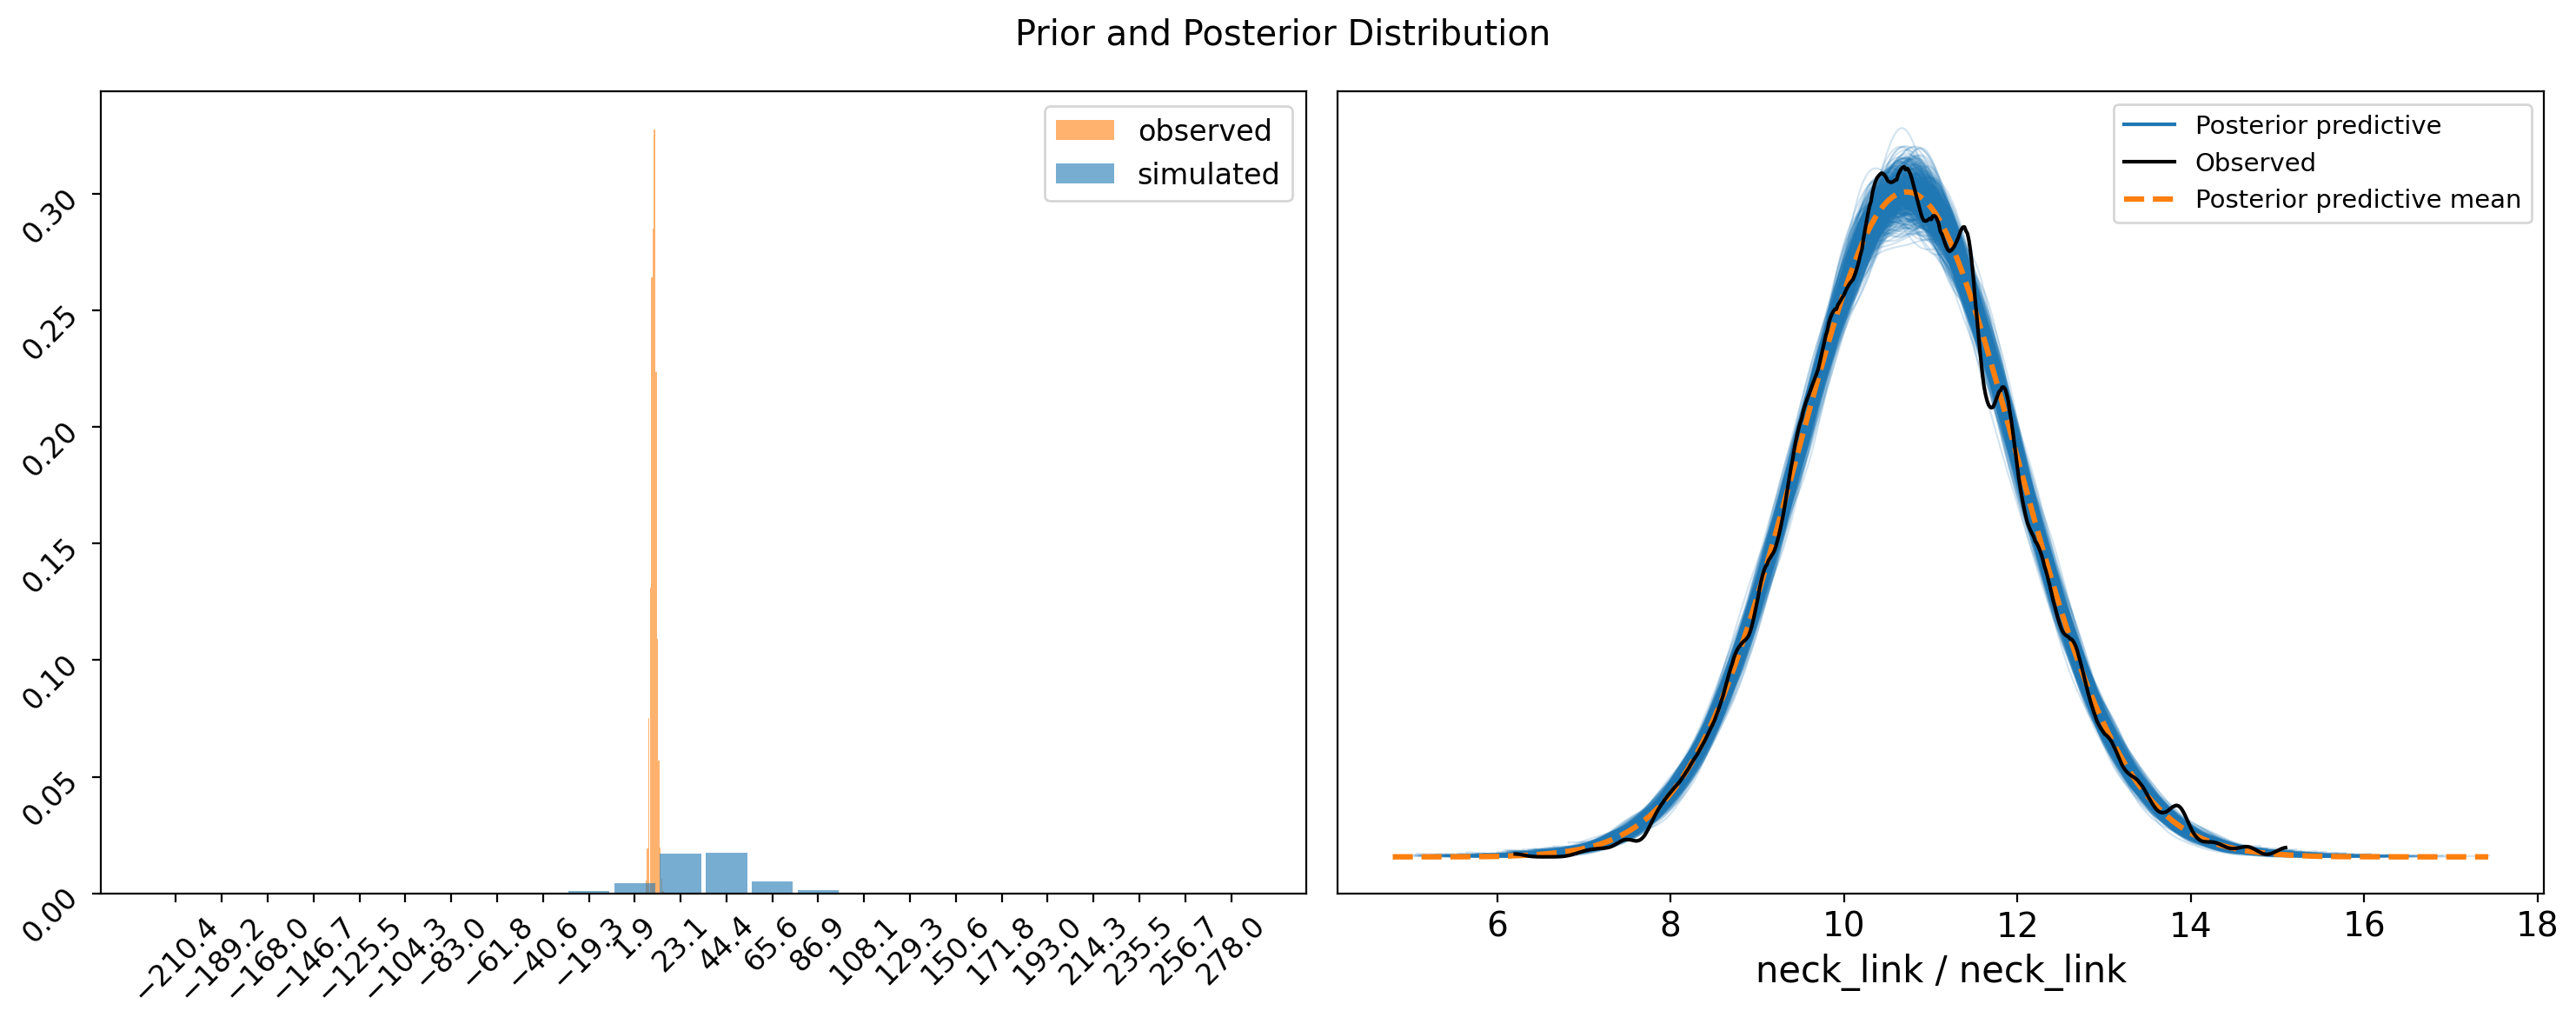

In [12]:
# plot 
fig, ax = plt.subplots(1,2,figsize=(15, 6))
fig.suptitle("Prior and Posterior Distribution ")
# plt.xticks(rotation=45);
ax[0].tick_params(labelrotation=45)
az.plot_dist(ansur_link,kind="hist", color="C1", hist_kwargs=dict(alpha=0.6),label="observed",ax= ax[0])
az.plot_dist(prior_samples.prior_predictive["neck_link"],kind="hist",hist_kwargs=dict(alpha=0.6),label="simulated",ax= ax[0])
az.plot_ppc(idata,var_names = "neck_link", num_pp_samples=600, ax = ax[1])
fig.tight_layout()

In [13]:
idata_df = idata.to_dataframe()

This plot helps to visualize the contribution of weight and height to the neck link. 
An increment in 10 cm in height contributes 0.76 cm in neck link for females and 0.72cm for males.
An increment of 1 BMI unit, corresponds to 0.39 cm for females and 0.5 cm for males in neck link. 

In [14]:
trace = az.extract(idata)

In [15]:
bmi_female = subset[subset['Gender'] == '0']['BMI']
bmi_male = subset[subset['Gender'] == '1']['BMI']
height_female = subset[subset['Gender'] == '0']['stature']
height_male = subset[subset['Gender'] == '1']['stature']

In [16]:
bmi_seq_female = np.linspace(bmi_female.min(), bmi_female.max(),4000);height_seq_female = np.linspace(height_female.min(), height_female.max(),4000)
bmi_seq_male = np.linspace(bmi_male.min(), bmi_male.max(),4000);height_seq_male = np.linspace(height_male.min(), height_male.max(),4000)

mu_pred_female = np.zeros((len(bmi_seq_female),trace.sizes["sample"]))
mu_pred_male = np.zeros((len(bmi_seq_male),trace.sizes["sample"]))
for i, (w_f,h_f,w_m,h_m) in enumerate(zip(bmi_seq_female, height_seq_female,bmi_seq_male, height_seq_male)):
    mu_pred_female[i] = trace["alpha"][0] + trace["gamma"][0] * (w_f- bmi_mean)  + trace["beta"][0] * (h_f - height_mean)
    mu_pred_male[i] = trace["alpha"][1] + trace["gamma"][1] * (w_m- bmi_mean)  + trace["beta"][1] * (h_m - height_mean)

circ_rng = np.random.default_rng(2971)
post_samples_female = [];post_samples_male = []
for _ in range(1000):  # number of samples from the posterior
    i = circ_rng.integers(len(trace))
    mu_pr_female = trace["alpha"][0][i].item(0) + trace["gamma"][0][i].item(0) * (bmi_seq_female - bmi_mean) + trace["beta"][0][i].item(0) * (height_seq_female - height_mean)
    mu_pr_male = trace["alpha"][1][i].item(0) + trace["gamma"][1][i].item(0) * (bmi_seq_male - bmi_mean) + trace["beta"][1][i].item(0) * (height_seq_male - height_mean)
    sigma_pred = trace["sigma"][i]
    post_samples_female.append(circ_rng.normal(mu_pr_female, sigma_pred))
    post_samples_male.append(circ_rng.normal(mu_pr_male, sigma_pred))

c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, 

Text(0, 0.5, 'Neck link [cm]')

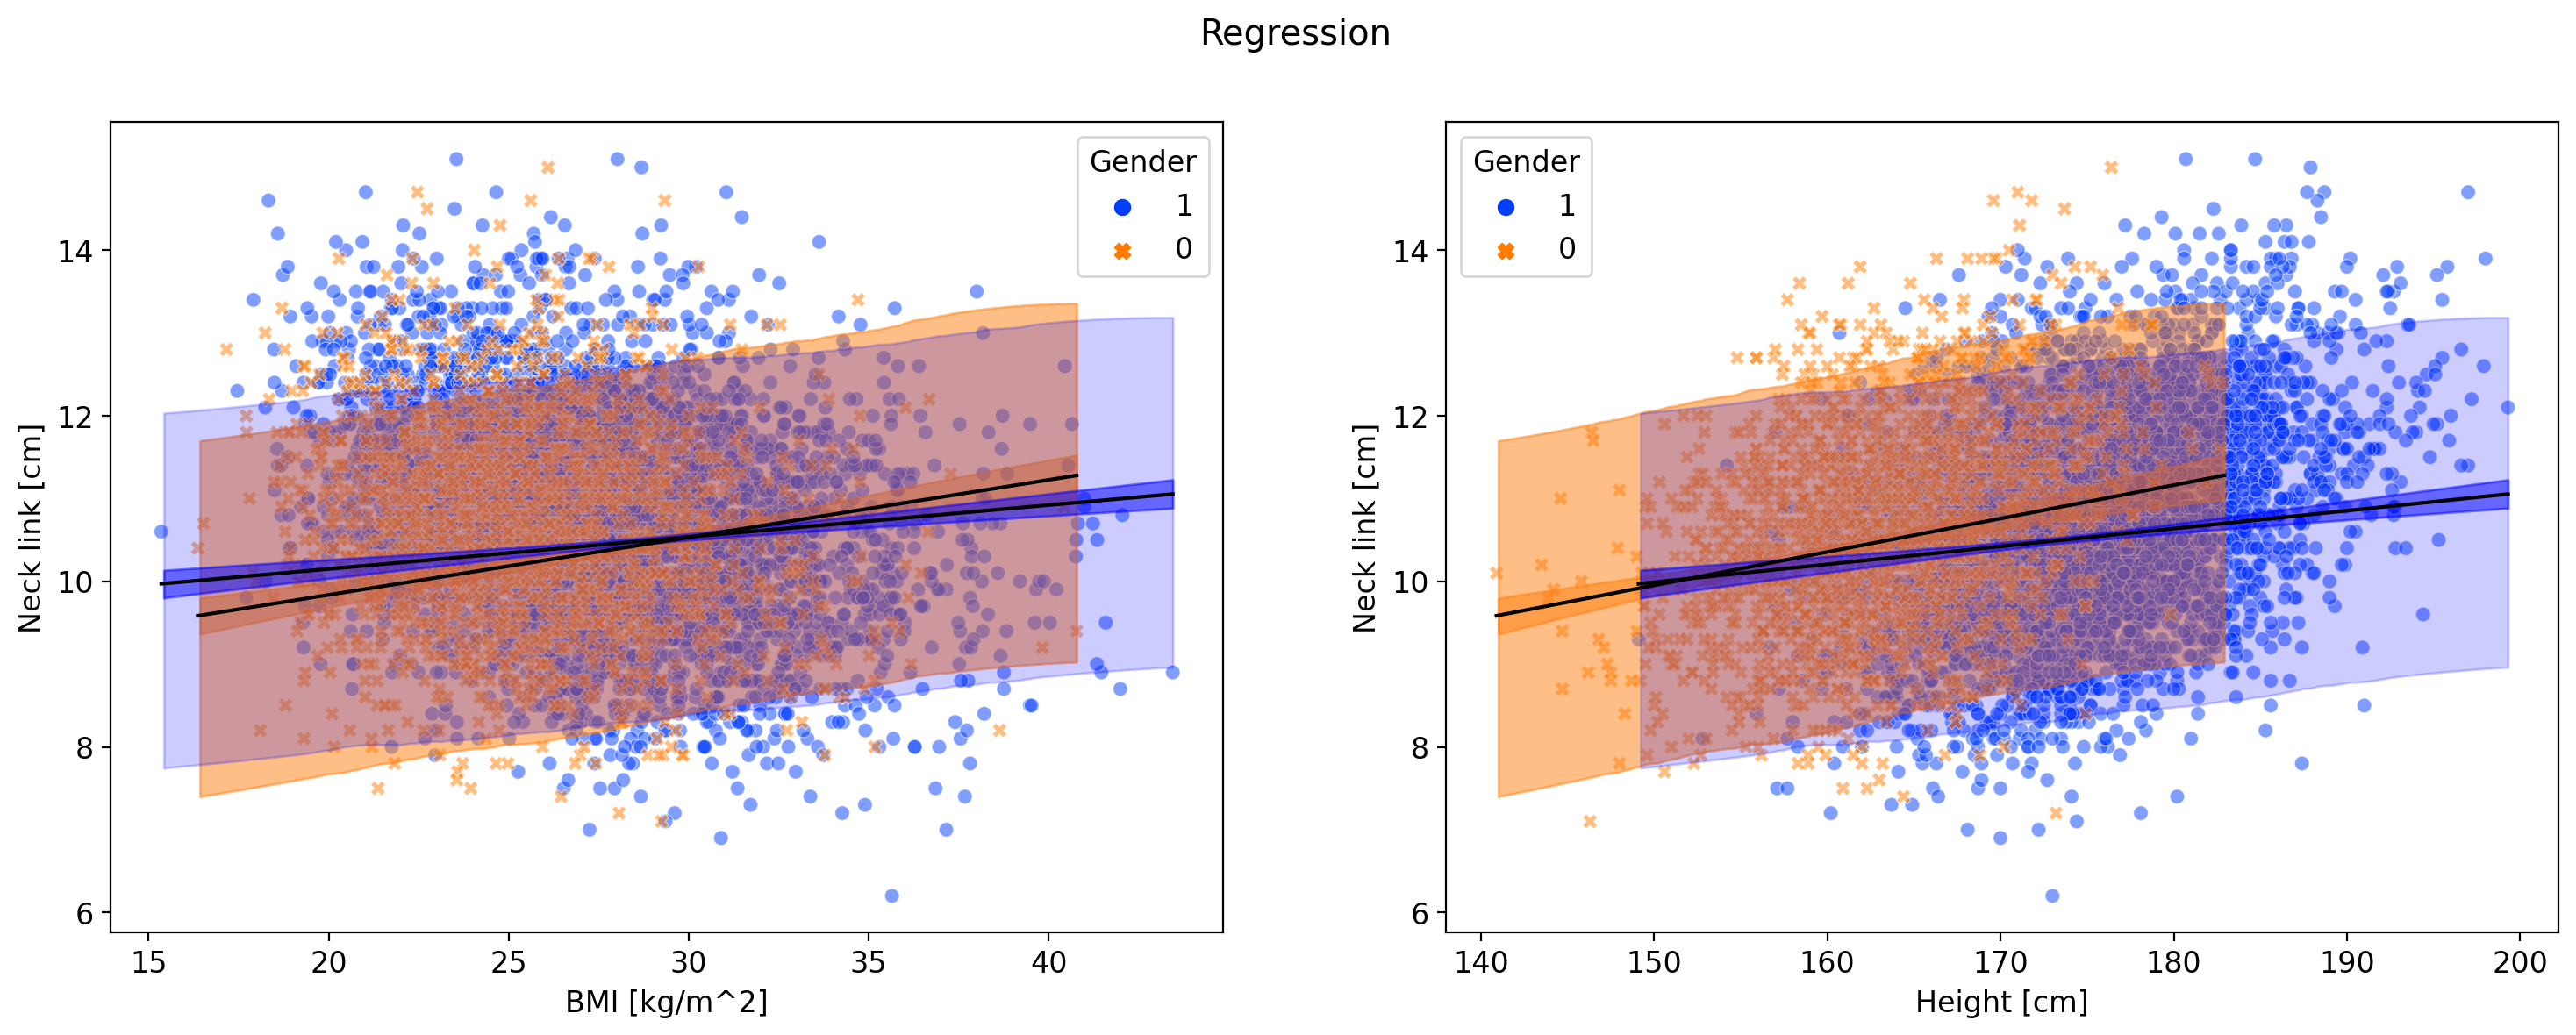

In [17]:
# PLOTS
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(18, 6))
fig.suptitle("Regression")    
sns.scatterplot(data=subset,y="necklink", x="BMI", hue="Gender", alpha = 0.5, ax= ax0, style="Gender",palette="bright")
# BMI
az.plot_hdi(bmi_seq_female, mu_pred_female.T, hdi_prob=0.95,ax=ax0)
az.plot_hdi(bmi_seq_female, np.array(post_samples_female), ax=ax0, hdi_prob=0.95)
ax0.plot(bmi_seq_female,mu_pred_female.mean(1), "k")
az.plot_hdi(bmi_seq_male, mu_pred_male.T, hdi_prob=0.95,ax= ax0, color="blue")
az.plot_hdi(bmi_seq_male, np.array(post_samples_male), ax=ax0, hdi_prob=0.95,color="blue",fill_kwargs={"alpha": .2})
ax0.plot(bmi_seq_male,mu_pred_male.mean(1), "k")
# Height 
sns.scatterplot(data=subset,y="necklink", x="stature", hue="Gender", alpha = 0.5,ax= ax1, style="Gender",palette="bright")
az.plot_hdi(height_seq_female, mu_pred_female.T, hdi_prob=0.95,ax= ax1)
az.plot_hdi(height_seq_female, np.array(post_samples_female), ax=ax1, hdi_prob=0.95)
ax1.plot(height_seq_female,mu_pred_female.mean(1), "k")
az.plot_hdi(height_seq_male, mu_pred_male.T, hdi_prob=0.95,color="blue",ax=ax1)
az.plot_hdi(height_seq_male, np.array(post_samples_male), ax=ax1, hdi_prob=0.95,color="blue",fill_kwargs={"alpha": .2})
ax1.plot(height_seq_male,mu_pred_male.mean(1), "k")

ax1.set_xlabel("Height [cm]"); ax1.set_ylabel("Neck link [cm]")
ax0.set_xlabel("BMI [kg/m^2]");ax0.set_ylabel("Neck link [cm]")

##### Posterior Mean

Predicting a sample of 1000 individuals.

PLOT 1:
Mean for female: 10.598 cm
Mean for male: 10.81 cm

PLOT 2:
Mean of the difference: 0.212 cm


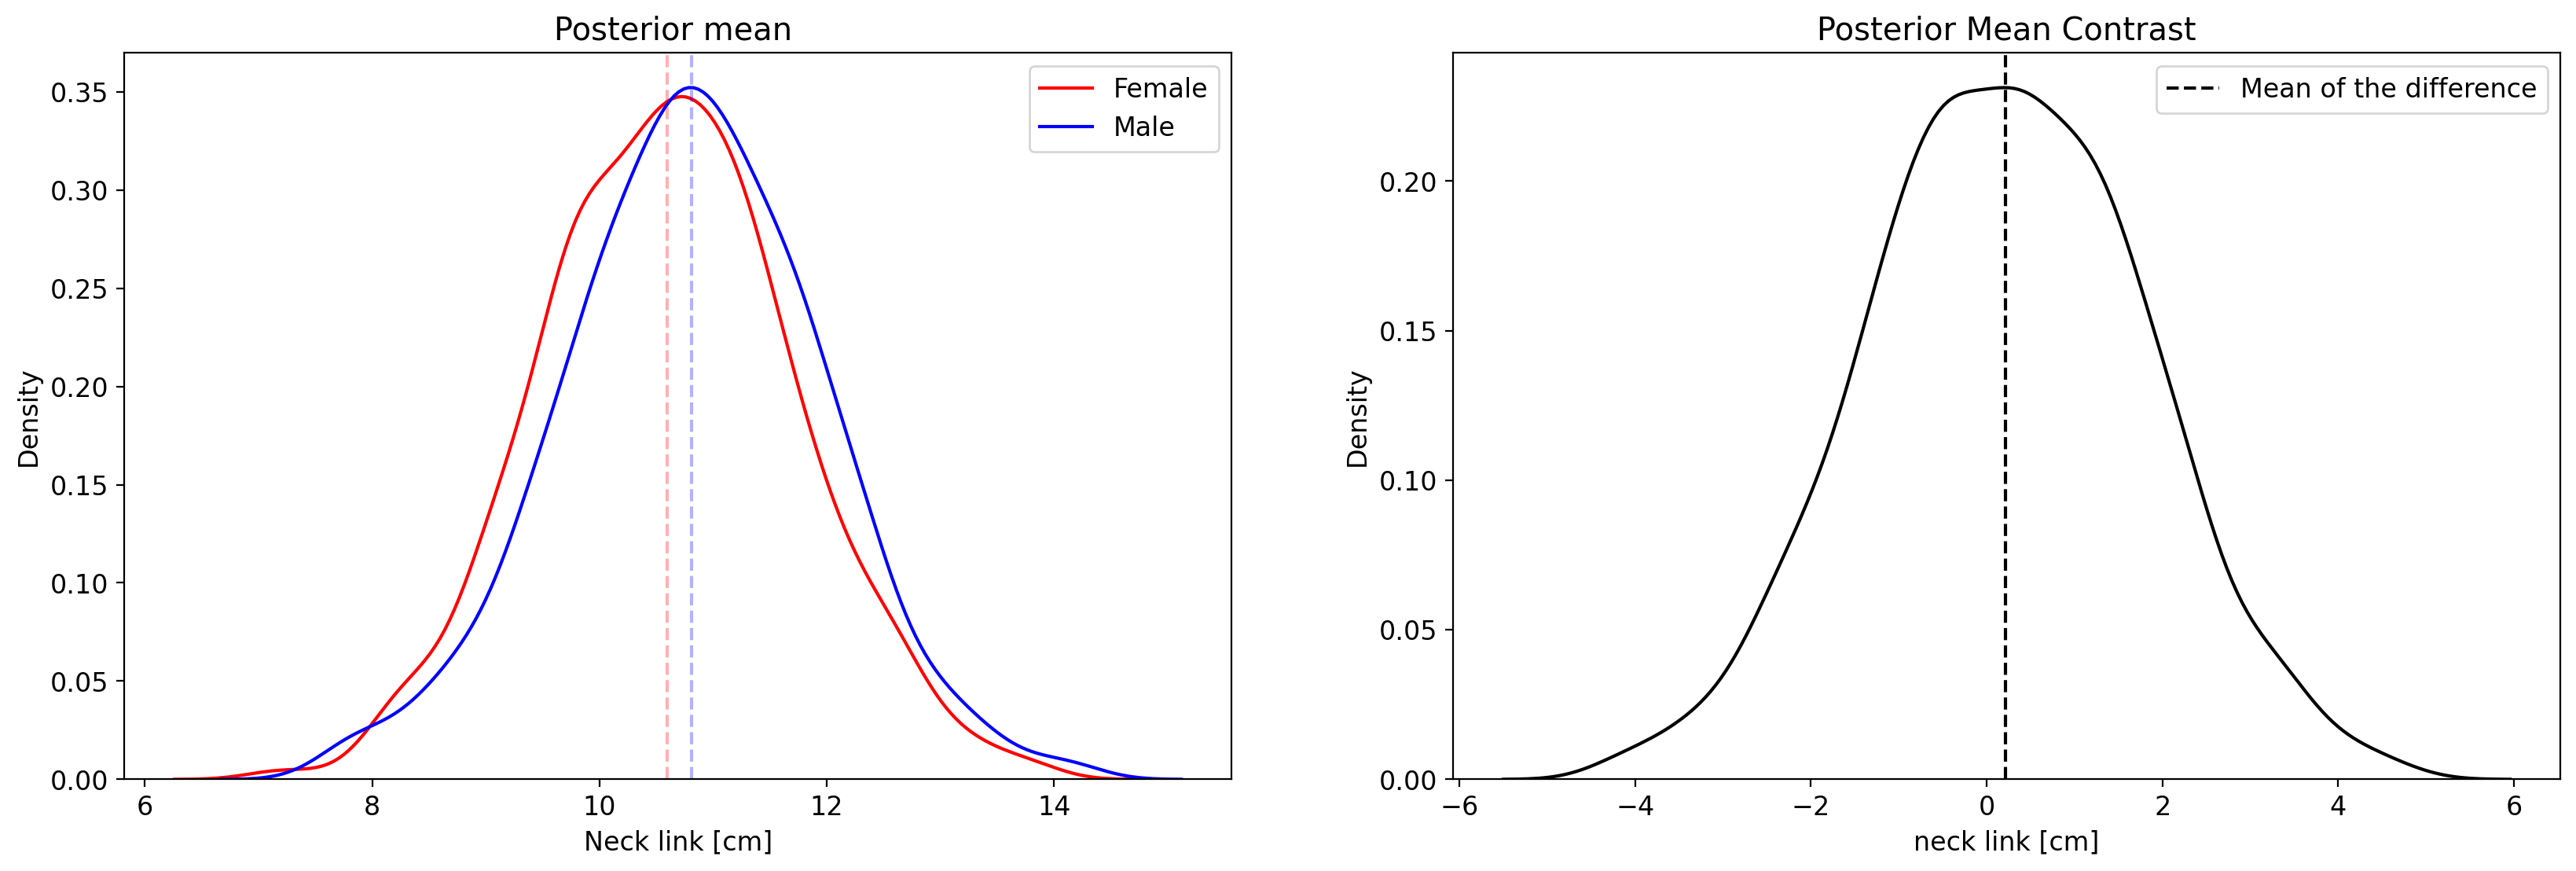

In [18]:
# Posterior Mean 
mu_female = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)][:1000] + idata_df[("posterior", "gamma[0]", 0)][:1000] * (bmi_female[:1000]  - bmi_mean) + idata_df[("posterior", "beta[0]", 0)][:1000] * (height_female[:1000]  - height_mean) ), size =1000 )
mu_male = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)][:1000] + idata_df[("posterior", "gamma[1]", 1)][:1000] * (bmi_male[:1000] - bmi_mean) + idata_df[("posterior", "beta[1]", 1)][:1000] * (height_male[:1000] - height_mean) ), size =1000 )
f, ax = plt.subplots(1,2 , figsize=(20, 6))
ax[0].set_title("Posterior mean ")
ax[0].set_xlabel("Neck link [cm]")
sns.kdeplot( mu_female, color="red", ax=ax[0], label= "Female")
sns.kdeplot( mu_male , color="blue", ax=ax[0], label= "Male")
ax[0].axvline(x=np.nanmean(np.nanmean(mu_female)), linestyle="dashed", color="red",alpha=0.3)
ax[0].axvline(x=np.nanmean(np.nanmean(mu_male)), linestyle="dashed", color="blue",alpha=0.3)
print(f"PLOT 1:")
print(f"Mean for female:", np.round(np.nanmean(mu_female),3), "cm")
print(f"Mean for male:", np.round(np.nanmean(mu_male),3), "cm")

ax[1].set_title("Posterior Mean Contrast")
ax[1].set_xlabel("neck link [cm]")
mu_contrast = mu_male - mu_female
sns.kdeplot(mu_contrast,color='black' ,ax=ax[1])

kde_x, kde_y = ax[1].lines[0].get_data()
ax[1].axvline(x=np.nanmean(mu_contrast), linestyle="dashed", color="black", label= "Mean of the difference")
ax[0].legend(); ax[1].legend();
print(f"\nPLOT 2:")
print(f"Mean of the difference:", np.round(np.nanmean(mu_contrast),3), "cm")

##### Posterior Distribution

Proportion above zero: 0.521
Proportion below zero: 0.479


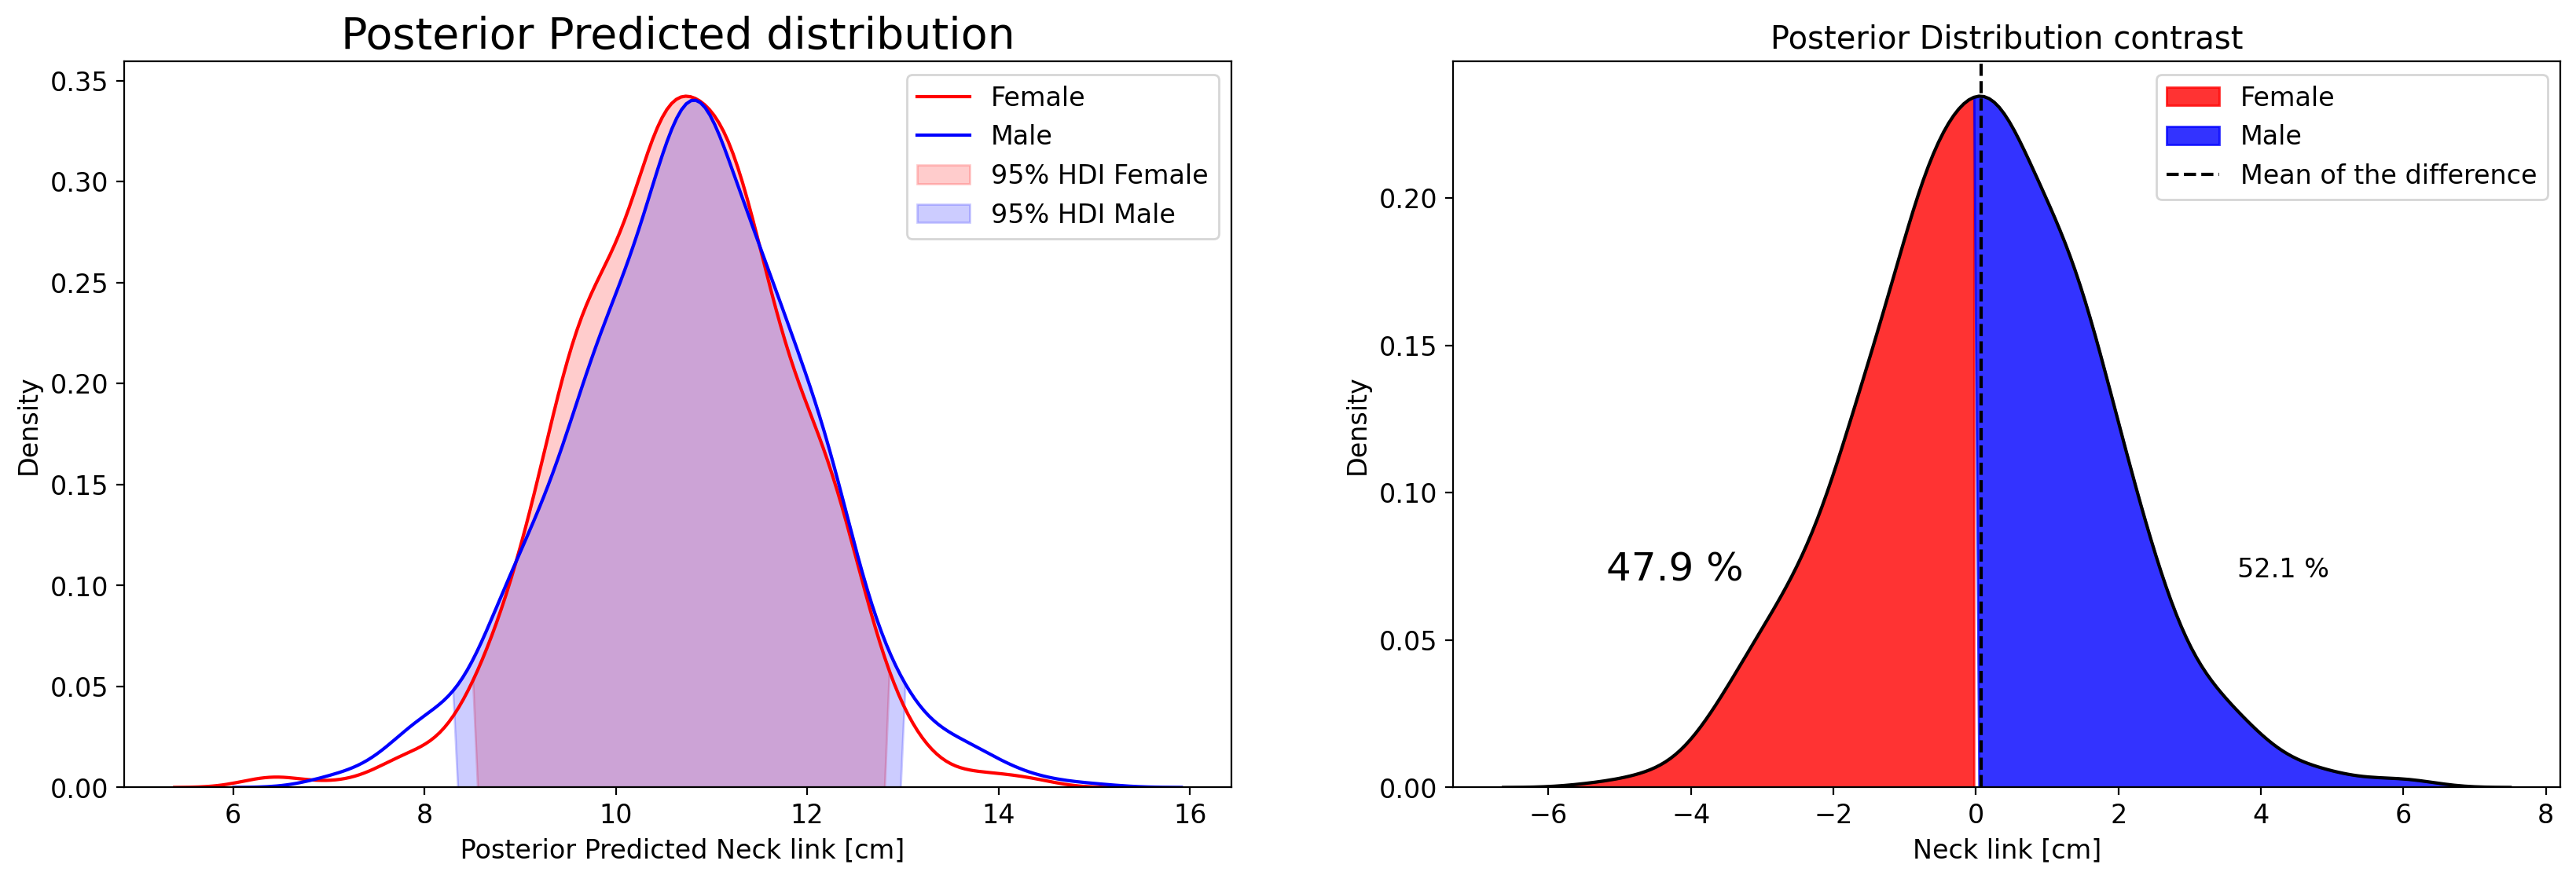

In [19]:
#| label: fig-contrast-distribution
#| fig-cap: "Posterior Distribution Contrast Neck link"
# posterior W distributions
f, ax = plt.subplots(1,2, figsize=(20, 6))
N0 = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (bmi_female[:1000]  - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_female[:1000] - height_mean) ), scale =idata_df[("posterior", "sigma")] )
N1 = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (bmi_male[:1000] - bmi_mean)    + idata_df[("posterior", "beta[1]", 1)] * (height_male[:1000] - height_mean) ), scale =idata_df[("posterior", "sigma")] )
sns.kdeplot(N0, color="red", label="Female", ax=ax[0])
sns.kdeplot(N1, color="blue", label="Male", ax=ax[0])

# HDI
#-----------------------
kde_female_x, kde_female_y = ax[0].lines[0].get_data()
low_female_int, high_female_int = az.hdi(N0[~np.isnan(N0)], hdi_prob=.95)
ax[0].fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax[0].lines[1].get_data()
low_male_int, high_male_int = az.hdi(N1[~np.isnan(N1)])
ax[0].fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
#------------------------------
ax[0].set(xlabel=" Posterior Predicted Neck link [cm]"); ax[0].set_title("Posterior Predicted distribution", fontsize=20)
ax[0].legend()

# contrast
N_contrast = N1 - N0
ax[1].set_title("Posterior Distribution contrast")
sns.kdeplot(N_contrast, color="black", ax=ax[1])
kde_x, kde_y = ax[1].lines[0].get_data()
ax[1].fill_between(kde_x, kde_y, where=kde_x < 0, color="red", alpha= 0.8, label="Female",interpolate=True)
ax[1].fill_between(kde_x, kde_y, where=kde_x > 0, color="blue", alpha= 0.8,label="Male", interpolate=True)
ax[1].set(xlabel="Neck link [cm]")
# proportion above zero
print(f"Proportion above zero: {np.round(sum((N_contrast[~np.isnan(N_contrast)]) > 0)  / len(N_contrast[~np.isnan(N_contrast)]),3)}")
# proportion below zero
print(f"Proportion below zero: {np.round(sum((N_contrast[~np.isnan(N_contrast)]) < 0)  / len(N_contrast[~np.isnan(N_contrast)]),3)}")
ax[1].axvline(x= np.nanmean(N_contrast), linestyle="dashed", color="black", label= "Mean of the difference")
perc = np.round(sum((N_contrast[~np.isnan(N_contrast)]) > 0)  / len(N_contrast[~np.isnan(N_contrast)]),3)
ax[1].text(0.75, 0.3, "%.1f %%"%(perc*100), horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[1].text(0.2, 0.3, "%.1f %%"%((1-perc)*100), horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize = 18)

ax[1].legend()

Contrast (Male - Female) for individual with average height or BMI for 50 samples.

Fixed Height - BMI varies 14 to 44 kg/m^2

Fixed BMI - Height varies 120-190 

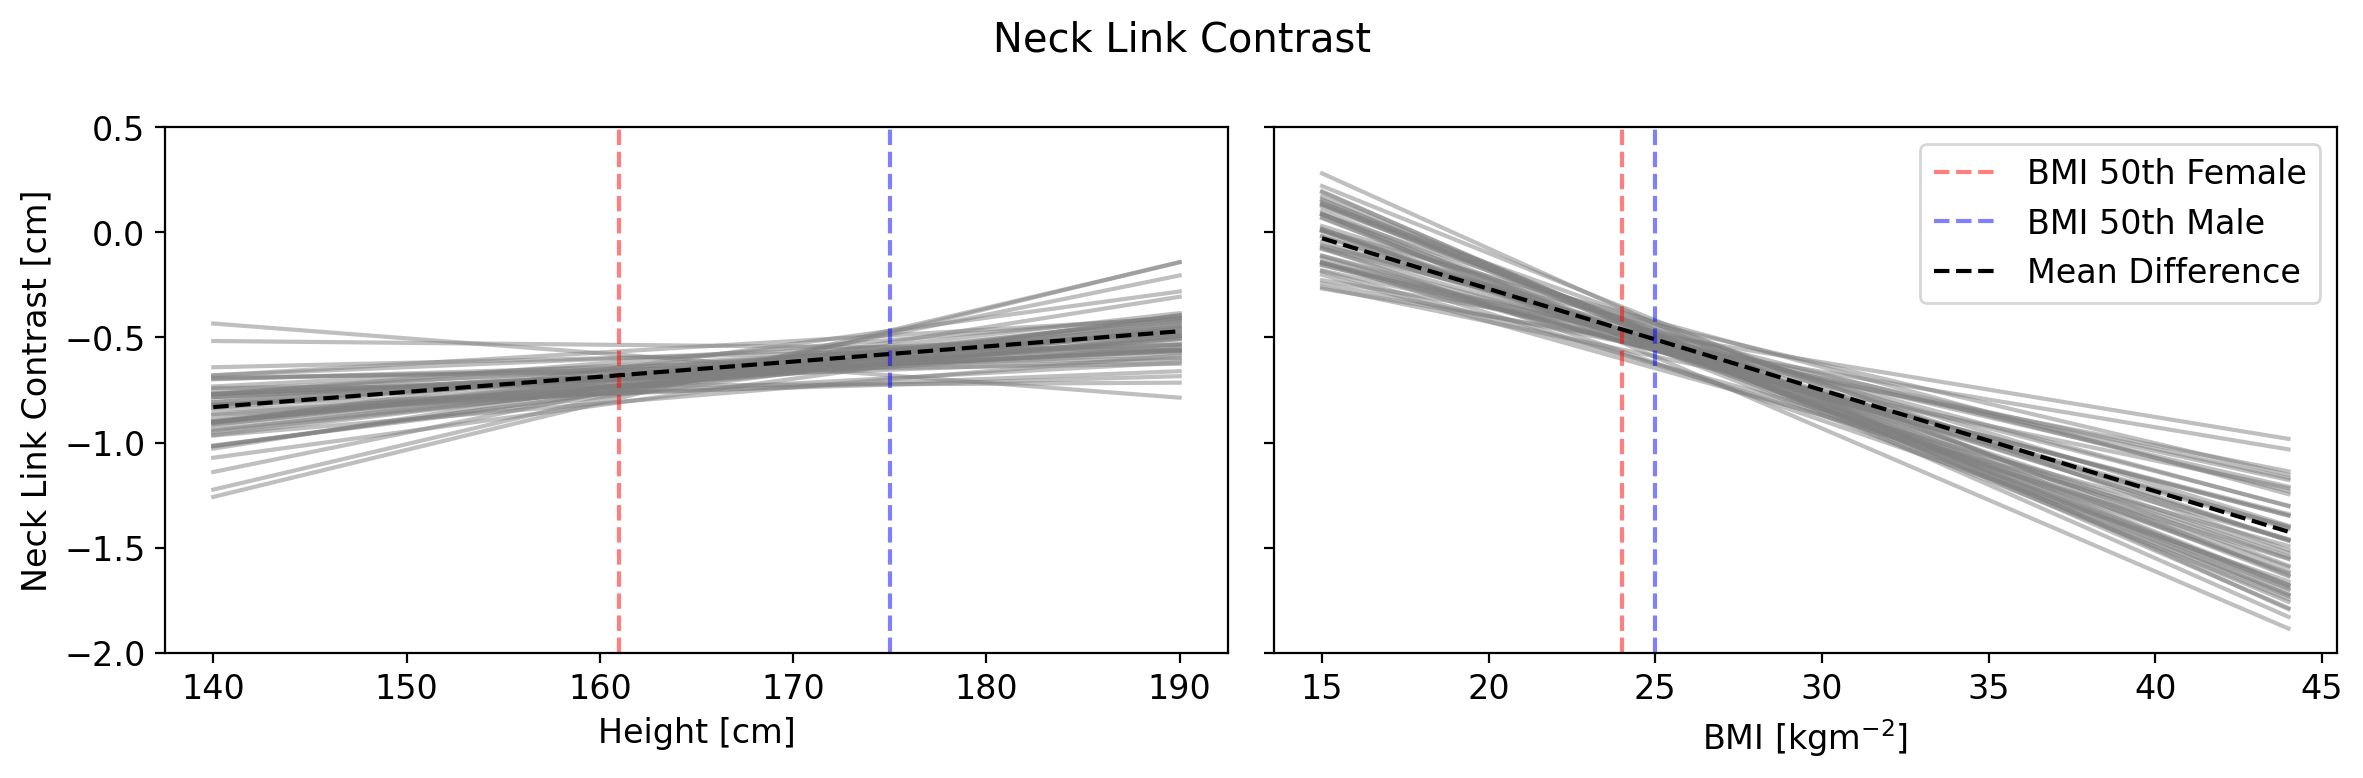

In [20]:
#| label: fig-contrast
#| fig-cap: "Posterior Contrast Neck link"
bmi_seq = np.linspace(15, 44, num=50)
hseq = np.linspace(140, 190, num=50)
# initialize dataframes
mu_F_bmi = np.zeros((len(idata_df), len(bmi_seq)))
mu_M_bmi = np.zeros((len(idata_df), len(bmi_seq)))
# Fill female and male predictions
for i, (x, h) in enumerate(zip(bmi_seq,hseq)):
    mu_F_bmi[:, i] = idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (x - bmi_mean) 
    mu_M_bmi[:, i] = idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (x - bmi_mean) 
mu_contrast_MF_bmi= mu_M_bmi - mu_F_bmi

# initialize dataframes
mu_F_height = np.zeros((len(idata_df), len(bmi_seq)))
mu_M_height = np.zeros((len(idata_df), len(bmi_seq)))
# Fill female and male predictions
for i, (x, h) in enumerate(zip(bmi_seq,hseq)):
    mu_F_height[:, i] = idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "beta[0]", 0)] * (h - height_mean) 
    mu_M_height[:, i] = idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "beta[1]", 1)] * (h - height_mean) 
mu_contrast_MF_height= mu_M_height - mu_F_height

f, ((ax0, ax1)) = plt.subplots(1, 2,figsize=(12, 4),sharey=True)
f.suptitle("Neck Link Contrast")
for i in range(50):
    ax1.plot(bmi_seq, mu_contrast_MF_bmi[i, :], color="gray", alpha=0.5)
    ax0.plot(hseq, mu_contrast_MF_height[i, :], color="gray", alpha=0.5)

ax1.axvline(x= 24, linestyle="dashed", color="red", label= "BMI 50th Female", alpha = 0.5)
ax1.axvline(x= 25, linestyle="dashed", color="blue", label= "BMI 50th Male", alpha = 0.5)
ax0.axvline(x= 161, linestyle="dashed", color="red", label= "Height 50th Female", alpha = 0.5)
ax0.axvline(x= 175, linestyle="dashed", color="blue", label= "Height 50th Male", alpha = 0.5)
ax0.plot(hseq, mu_contrast_MF_height.mean(axis=0), color="black", linestyle='--', label ="Mean Difference")
ax0.set(xlabel="Height [cm]", ylabel="Neck Link Contrast [cm]"); #ax0.set_title("Fixed BMI")
ax1.plot(bmi_seq, mu_contrast_MF_bmi.mean(axis=0), color="black", linestyle='--',label ="Mean Difference"); ax0.set_ylim([-2,0.5])
ax1.set(xlabel="BMI [kgm$^{-2}$]")
ax1.legend()
f.tight_layout()
# plt.savefig("images/Neck_link-contrast.png")

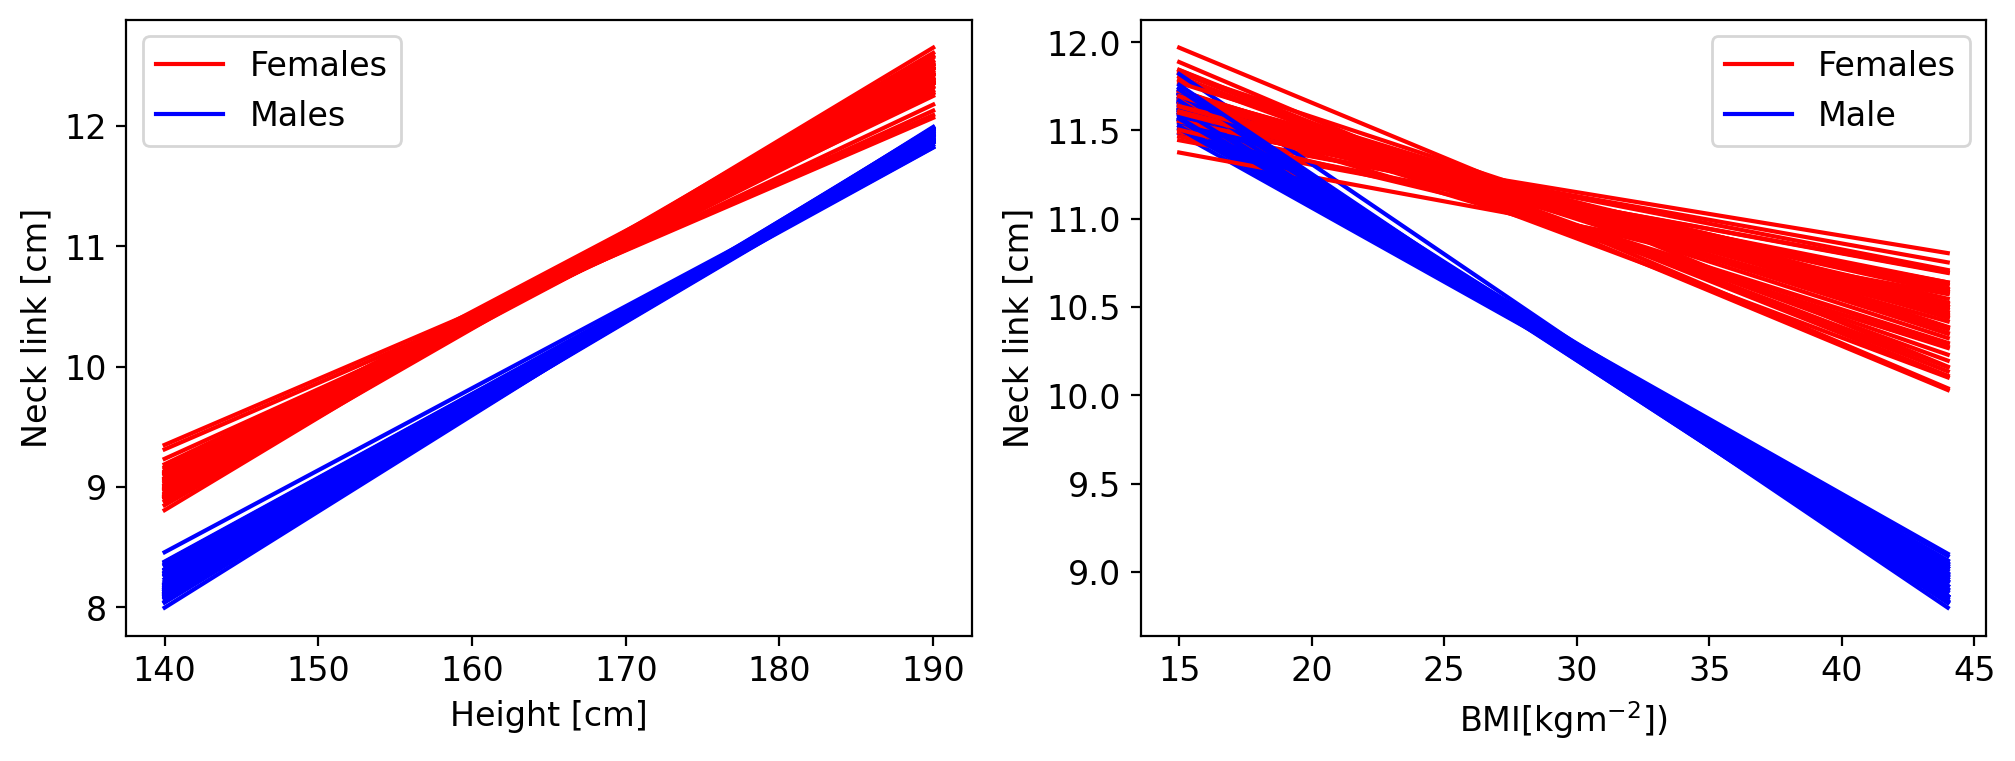

In [21]:
f, ((ax2,ax3)) = plt.subplots(1, 2, figsize=(12, 4))
for i in range(50):
    if i == 0:
        ax2.plot(hseq, mu_F_height[i, :], color="red", label="Females")
        ax2.plot(hseq, mu_M_height[i, :], color="blue", label="Males")
    else:
        ax2.plot(hseq, mu_F_height[i, :], color="red")
        ax2.plot(hseq, mu_M_height[i, :], color="blue")
ax2.set(xlabel="Height [cm]", ylabel="Neck link [cm]")
ax2.legend()
for i in range(50):
    if i == 0:
        ax3.plot(bmi_seq, mu_F_bmi[i, :], color="red", label="Females")
        ax3.plot(bmi_seq, mu_M_bmi[i, :], color="blue", label="Male")
    else:
        ax3.plot(bmi_seq, mu_F_bmi[i, :], color="red")
        ax3.plot(bmi_seq, mu_M_bmi[i, :], color="blue")
ax3.set(xlabel="BMI[kgm$^{-2}$])", ylabel="Neck link [cm]")
ax3.legend()

##### Posterior predictive plot

In [22]:
with model:
    ansur_reg_ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "neck_link"])

mu_mean = ansur_reg_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(ansur_reg_ppc.posterior_predictive["mu"], 0.95)

neck_sim = ansur_reg_ppc.posterior_predictive["neck_link"].mean(dim=["chain", "draw"])
neck_PI = az.hdi(ansur_reg_ppc.posterior_predictive["neck_link"], 0.95)

Sampling: [neck_link]


In [23]:
ansur_link_std =  (ansur_link.values -  ansur_link.values.mean())/  ansur_link.values.std()
neck_sim_std =  (neck_sim.values -  neck_sim.values.mean())/  neck_sim.values.std()

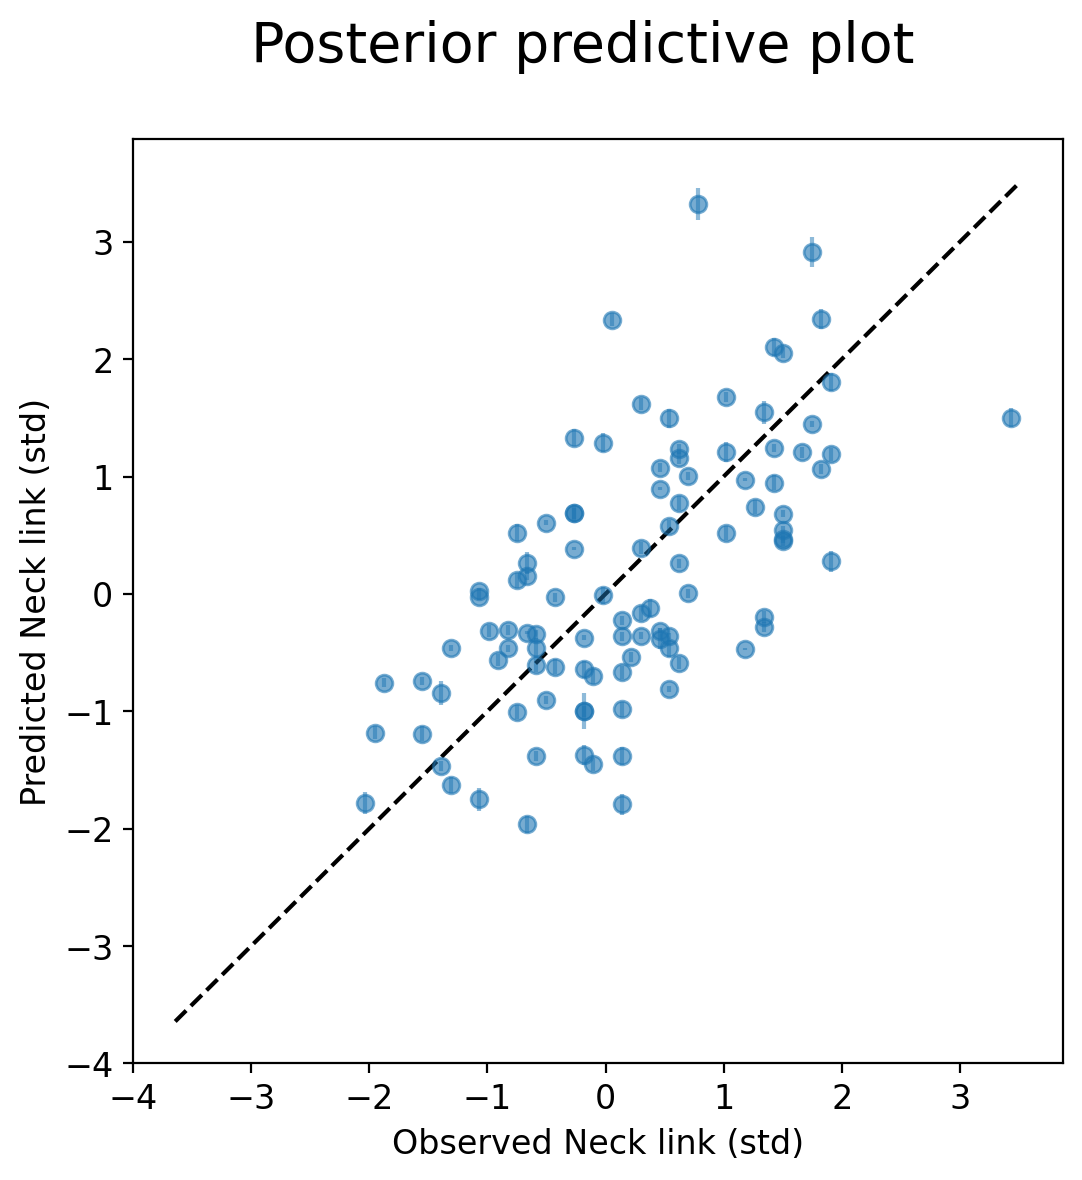

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Posterior predictive plot", fontsize= 20)
plt.errorbar(
    ansur_link_std[:100],
    neck_sim_std[:100],
    alpha=0.5,
    yerr=np.abs(np.array(neck_sim) - mu_PI.min(dim="hdi").to_array()).values[:,:100],
    fmt="C0o", 
)
ax.scatter(ansur_link_std[:100], neck_sim_std[:100], alpha= 0.2)
min_x, max_x = ansur_link_std.min(), ansur_link_std.max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")
ax.set_ylabel("Predicted Neck link (std)")
ax.set_xlabel("Observed Neck link (std)");

### Predict a specific individual
> Female of Height 161cm and BMI 24kg / m^2

> Male of Height 175cm and BMI 25kg / m^2

In [25]:
# Distribution for specific values of height and BMI
female_height = 161;female_BMI = 24
male_height = 175;male_BMI = 25
viva50F_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (female_BMI - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (female_height - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50F_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (female_BMI - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (female_height - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (male_BMI - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (male_height - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (male_BMI - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (male_height - height_mean)), scale=idata_df[("posterior", "sigma")])

Neck link distribution for individual [BMI=24 kg/m$^2$, Height=161 cm]

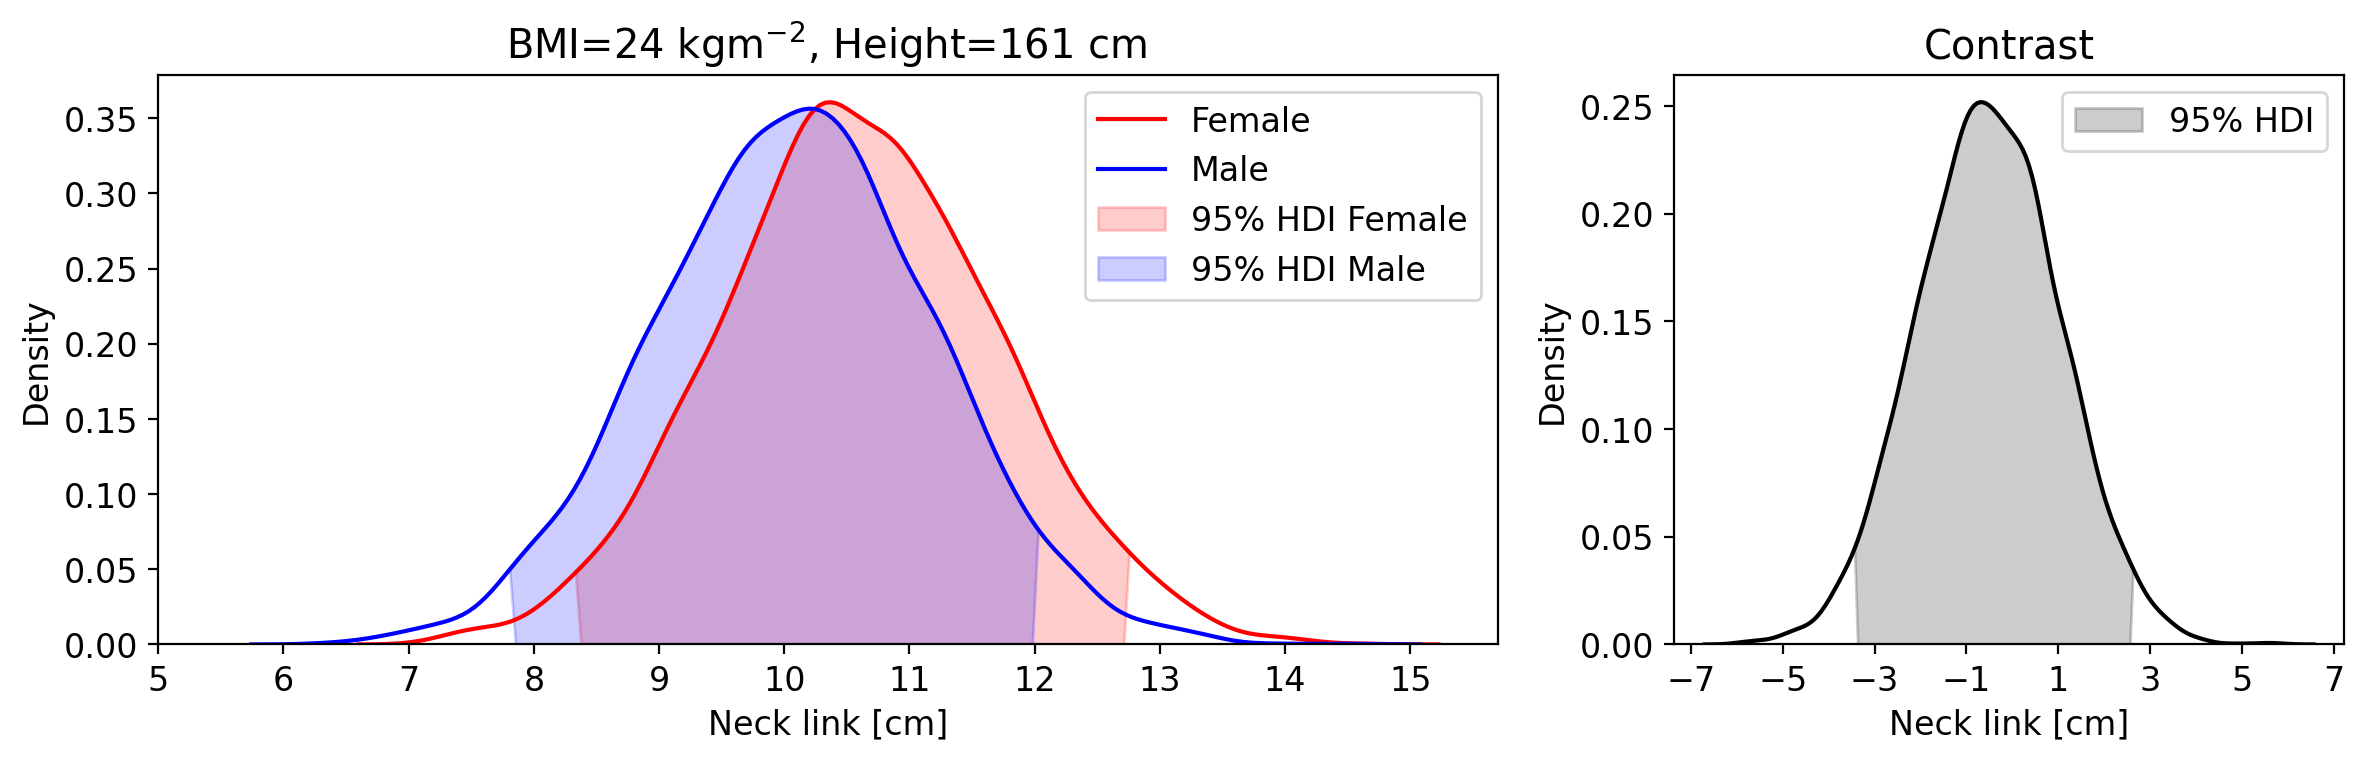

In [26]:
f, (ax0,ax1) = plt.subplots(1,2,figsize=(12, 4),gridspec_kw={'width_ratios': [2, 1]})
ax0.set_title("BMI=24 kgm$^{-2}$, Height=161 cm ")
sns.kdeplot(viva50F_F, color="r", ax=ax0)
sns.kdeplot(viva50F_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50F_F[~np.isnan(viva50F_F)], hdi_prob=.95)
ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50F_M[~np.isnan(viva50F_M)])
ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
# sns.kdeplot(viva50F_M - viva50F_F, color="black", alpha =0.5,ax=ax0)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck link [cm]")
ax0.legend(["Female","Male", "95% HDI Female","95% HDI Male"])


ax1.set_title("Contrast");ax1.set(xlabel="Neck link [cm]")
sns.kdeplot((viva50F_M -viva50F_F)  , color="black", ax=ax1)
kde_contrast_x, kde_contrast_y = ax1.lines[0].get_data()
low_contrast_int, high_contrast_int = az.hdi((viva50F_M -viva50F_F)[~np.isnan(viva50F_M -viva50F_F)], hdi_prob=.95)
ax1.fill_between(kde_contrast_x, kde_contrast_y, where=(low_contrast_int< kde_contrast_x)& ( kde_contrast_x <high_contrast_int), color="black", alpha= 0.2, label="95% HDI",interpolate=True)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(np.round(start), end, 2))
ax1.legend()

f.tight_layout()
plt.savefig("../images/Neck_link.png")

### Comparing Avergae 50F and 50M

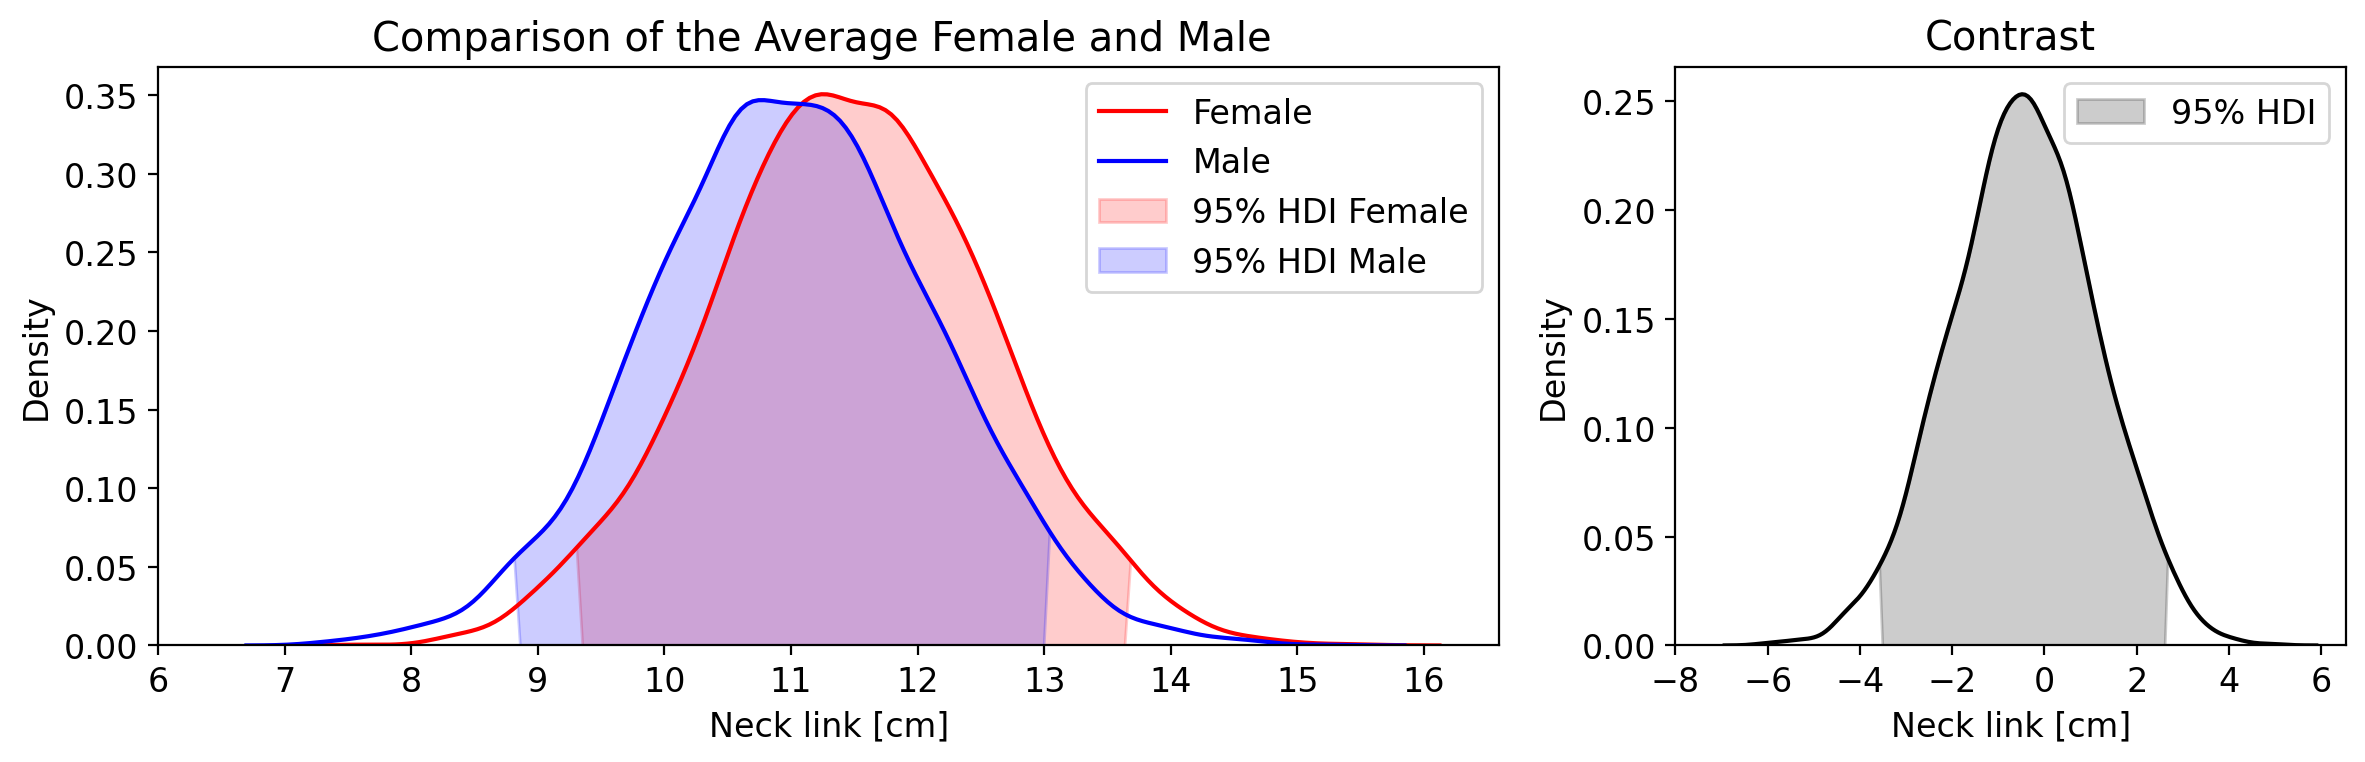

In [27]:
f, (ax0,ax1) = plt.subplots(1,2,figsize=(12, 4),gridspec_kw={'width_ratios': [2, 1]})
ax0.set_title("Comparison of the Average Female and Male ")
sns.kdeplot(viva50M_F, color="r", ax=ax0)
sns.kdeplot(viva50M_M, color="b", ax=ax0)
kde_female_x, kde_female_y = ax0.lines[0].get_data()
low_female_int, high_female_int = az.hdi(viva50M_F[~np.isnan(viva50M_F)], hdi_prob=.95)
ax0.fill_between(kde_female_x, kde_female_y, where=(low_female_int< kde_female_x)& ( kde_female_x <high_female_int), color="red", alpha= 0.2, label="95% HDI Female",interpolate=True)
kde_male_x, kde_male_y = ax0.lines[1].get_data()
low_male_int, high_male_int = az.hdi(viva50M_M[~np.isnan(viva50M_M)])
ax0.fill_between(kde_male_x, kde_male_y, where=(low_male_int< kde_male_x)& ( kde_male_x <high_male_int), color="blue", alpha= 0.2, label="95% HDI Male",interpolate=True)
# sns.kdeplot(viva50M_M - viva50M_F, color="black", alpha =0.5,ax=ax0)
start, end = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(np.round(start), end, 1))
ax0.set(xlabel="Neck link [cm]")
ax0.legend(["Female","Male", "95% HDI Female","95% HDI Male"])


ax1.set_title("Contrast");ax1.set(xlabel="Neck link [cm]")
sns.kdeplot((viva50M_M -viva50M_F)  , color="black", ax=ax1)
kde_contrast_x, kde_contrast_y = ax1.lines[0].get_data()
low_contrast_int, high_contrast_int = az.hdi((viva50M_M -viva50M_F)[~np.isnan(viva50M_M -viva50M_F)], hdi_prob=.95)
ax1.fill_between(kde_contrast_x, kde_contrast_y, where=(low_contrast_int< kde_contrast_x)& ( kde_contrast_x <high_contrast_int), color="black", alpha= 0.2, label="95% HDI",interpolate=True)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(np.round(start), end, 2))
ax1.legend()
f.tight_layout()
f.savefig("../images/Neck_link_Average.png")

## Distribution for different Percentiles

In [28]:
# Distribution for specific values of height and BMI
# data of percentiles taken from  https://ourworldindata.org/human-height 

height_5th_F = 150.6; BMI_5th_F= 25;
height_5th_M = 163.2;  BMI_5th_M= 25

height_50th_F = 164.7; BMI_50th_F = 25; 
height_50th_M= 178.4; BMI_50th_ = 25

height_95th_F = 178.9 ; BMI_95th_F = 25
height_95th_M = 193.6 ; BMI_95th_M= 25



# viva50F_F = this one has the height and BMI of female 50th and posterior of female (0) - female 100%
# viva50F_M = this one has the height and BMI of female 50th and posterior of males (1) - male with female size
viva50F_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (BMI_50th_F - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_50th_F - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50F_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (BMI_50th_F - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (height_50th_F - height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (BMI_50th_ - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_50th_M- height_mean)), scale=idata_df[("posterior", "sigma")])
viva50M_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (BMI_50th_ - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (height_50th_M- height_mean)), scale=idata_df[("posterior", "sigma")])

dummy5th_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (BMI_5th_F - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_5th_F - height_mean)), scale=idata_df[("posterior", "sigma")])
dummy5th_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (BMI_5th_M  - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (height_5th_M - height_mean)), scale=idata_df[("posterior", "sigma")])

dummy95th_F = norm.rvs(loc= (idata_df[("posterior", "alpha[0]", 0)] + idata_df[("posterior", "gamma[0]", 0)] * (BMI_95th_F - bmi_mean) + idata_df[("posterior", "beta[0]", 0)] * (height_95th_F - height_mean)), scale=idata_df[("posterior", "sigma")])
dummy95th_M = norm.rvs(loc= (idata_df[("posterior", "alpha[1]", 1)] + idata_df[("posterior", "gamma[1]", 1)] * (BMI_95th_M - bmi_mean) + idata_df[("posterior", "beta[1]", 1)] * (height_95th_M - height_mean)), scale=idata_df[("posterior", "sigma")])



## # PLot only 50th percentile 

c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


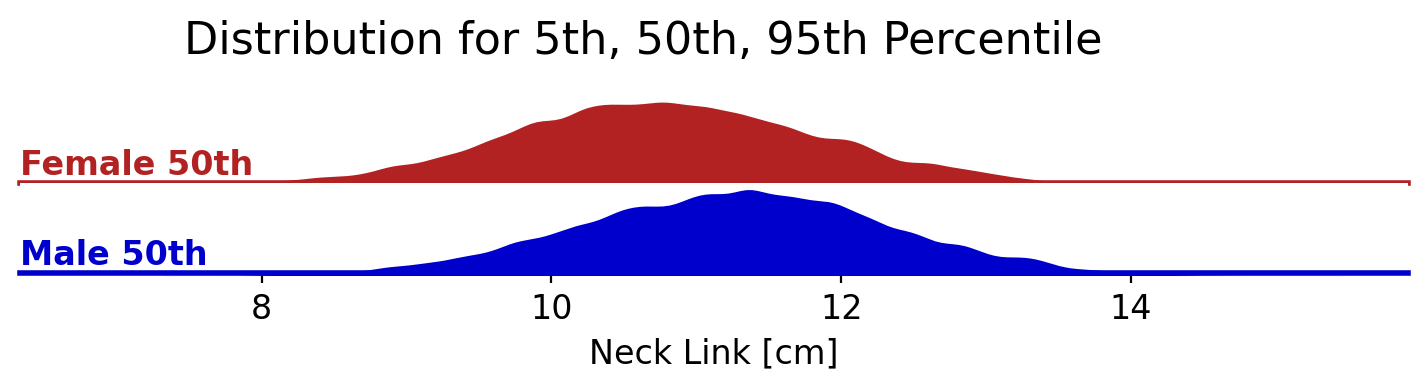

In [29]:
# Combine the data into a DataFrame
groups =['Female 50th'] * 4000 + ['Male 50th'] * 4000 
x = np.concatenate([viva50F_F, viva50M_M ])

df = pd.DataFrame(dict(x=x, g=groups))

# Initialize the FacetGrid object

g = sns.FacetGrid(df, row="g", hue="g", aspect=8, height=1, palette=["firebrick", "mediumblue"])
# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# # Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.001)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle("Distribution for 5th, 50th, 95th Percentile", fontsize=16)
# Set the x-axis label for the last subplot
g.set_axis_labels("Neck Link [cm]", "")
plt.show()

c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\chiarar\Anaconda3\envs\quarto-manuscript\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


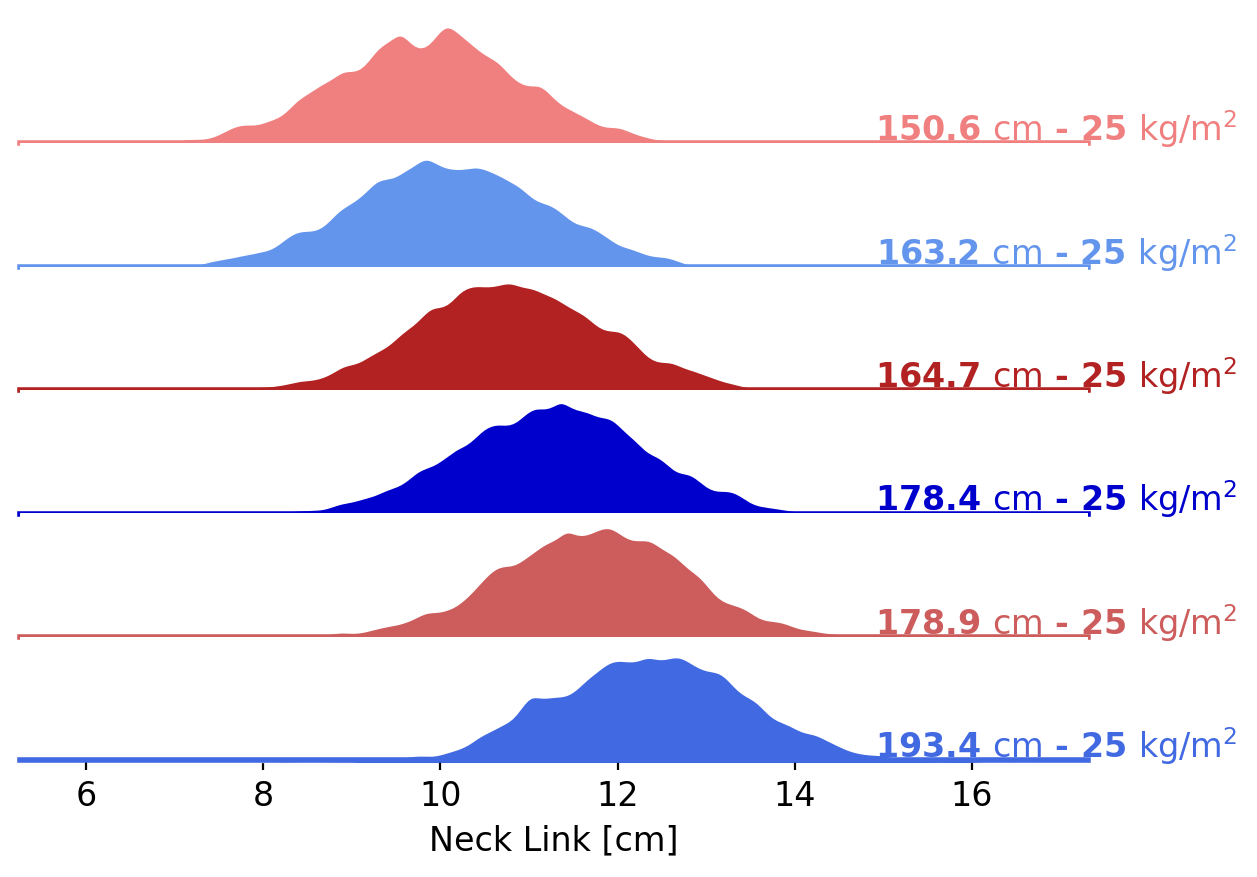

In [44]:
# Combine the data into a DataFrame
groups = ['Female 5th'] * 4000 + ['Male 5th'] * 4000 + ['Female 50th'] * 4000 + ['Male 50th'] * 4000 + ['Female 95th'] * 4000 + ['Male 95th'] * 4000 
x = np.concatenate([dummy5th_F, dummy5th_M, viva50F_F, viva50M_M ,dummy95th_F, dummy95th_M])

df = pd.DataFrame(dict(x=x, g=groups))

# Initialize the FacetGrid object

g = sns.FacetGrid(df, row="g", hue="g", aspect=8, height=.8, palette=["lightcoral", "cornflowerblue",  "firebrick", "mediumblue", "indianred" ,"royalblue"])
# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)

# g.map(label, "x")

text=[ "150.6 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
      "163.2 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
      "164.7 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
      "178.4 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
      "178.9 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$",
      "193.4 $\\mathrm{cm}$ - 25 $\\mathrm{kg/m^2}$"]

for i, ax in enumerate(g.axes.flat):
    ax.text( 1.14, 0.02, text[i], fontweight="bold", ha='right',transform=ax.transAxes, # use axes coordinates
            fontsize=12,
            color=ax.lines[-1].get_color())

# # Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.001)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# g.fig.suptitle("Distribution for 5th, 50th, 95th Percentile", fontsize=16)
# Set the x-axis label for the last subplot
g.set_axis_labels("Neck Link [cm]", "")
plt.show()

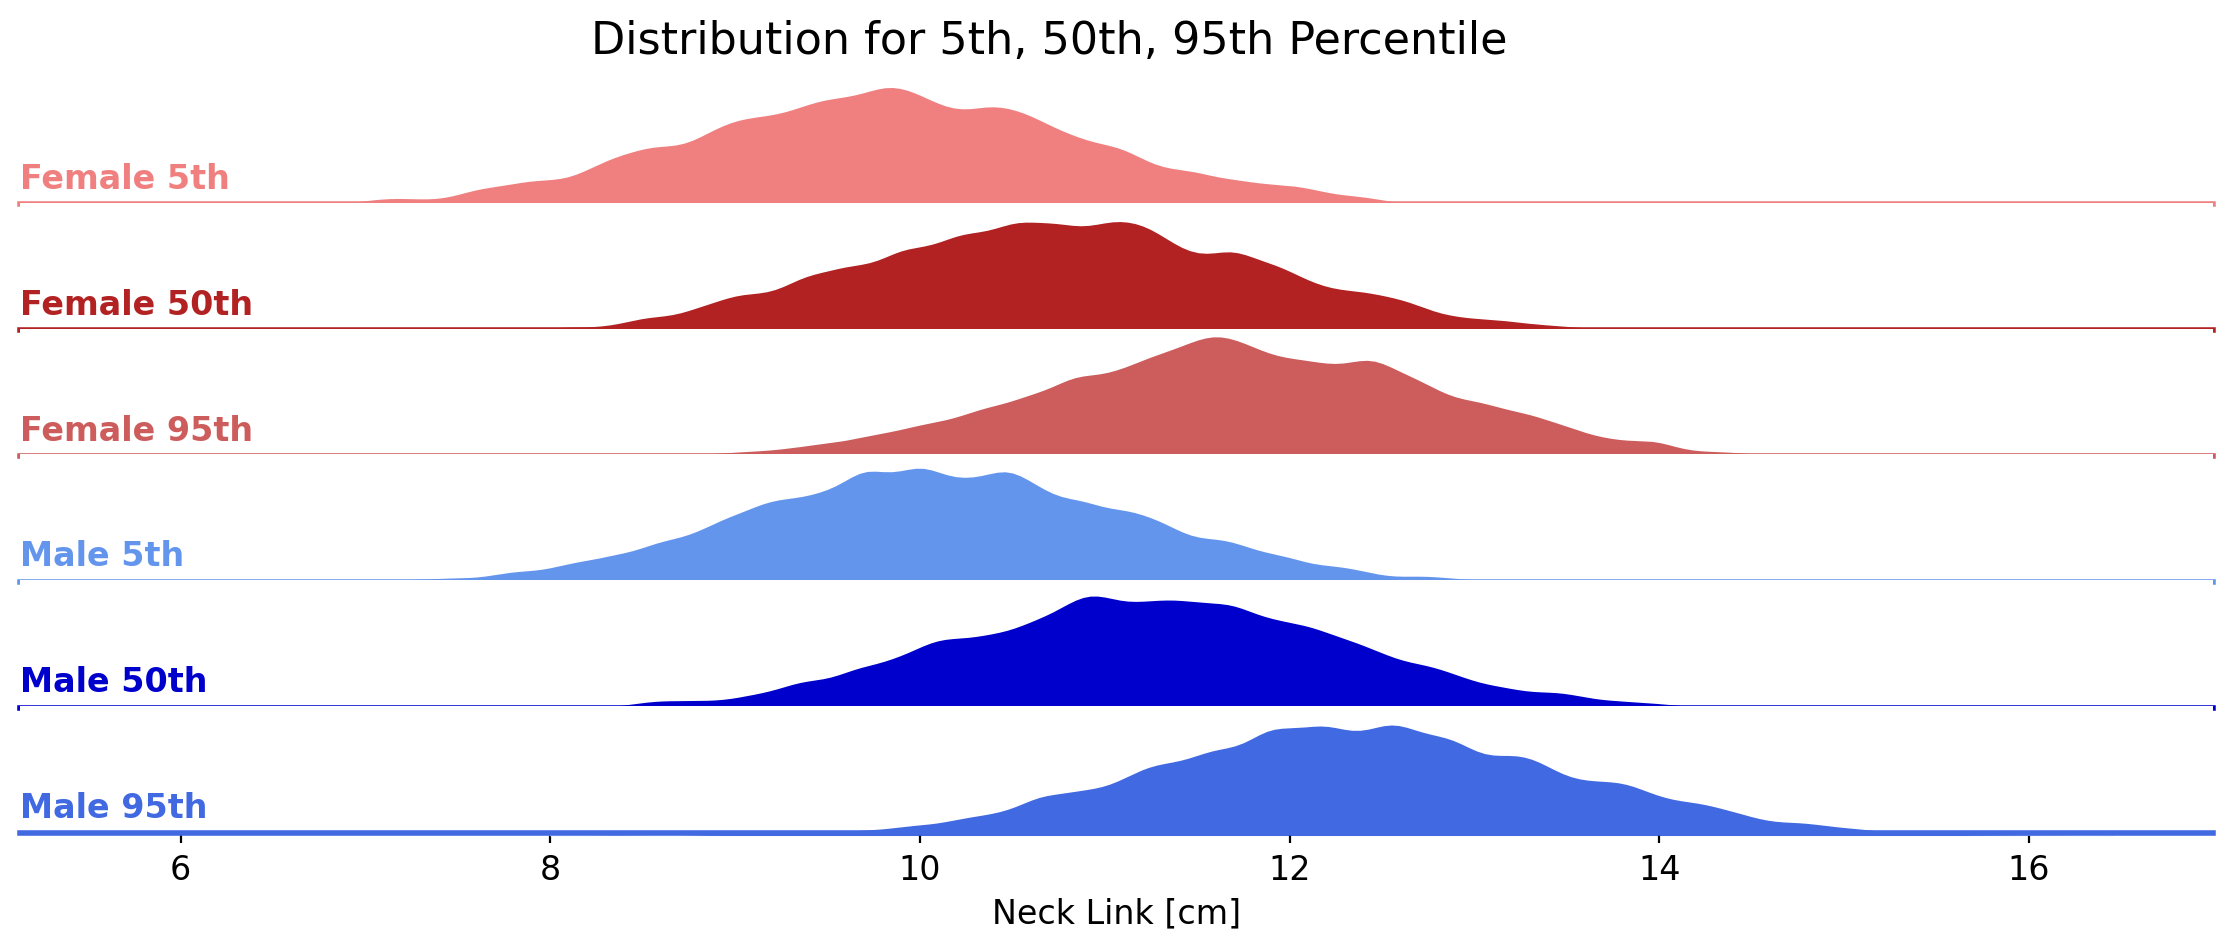

In [71]:
# Combine the data into a DataFrame
groups = ['Female 5th'] * 4000 + ['Female 50th'] * 4000  + ['Female 95th'] * 4000 + ['Male 5th'] * 4000 +  ['Male 50th'] * 4000 +  ['Male 95th'] * 4000 
x = np.concatenate([dummy5th_F, viva50F_F ,dummy95th_F,  dummy5th_M, viva50M_M , dummy95th_M])

df = pd.DataFrame(dict(x=x, g=groups))

# Initialize the FacetGrid object

g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.8, palette=["lightcoral", "firebrick", "indianred", "cornflowerblue", "mediumblue","royalblue",])
# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# # Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.01)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle("Distribution for 5th, 50th, 95th Percentile", fontsize=16)
# Set the x-axis label for the last subplot
g.set_axis_labels("Neck Link [cm]", "")
plt.show()

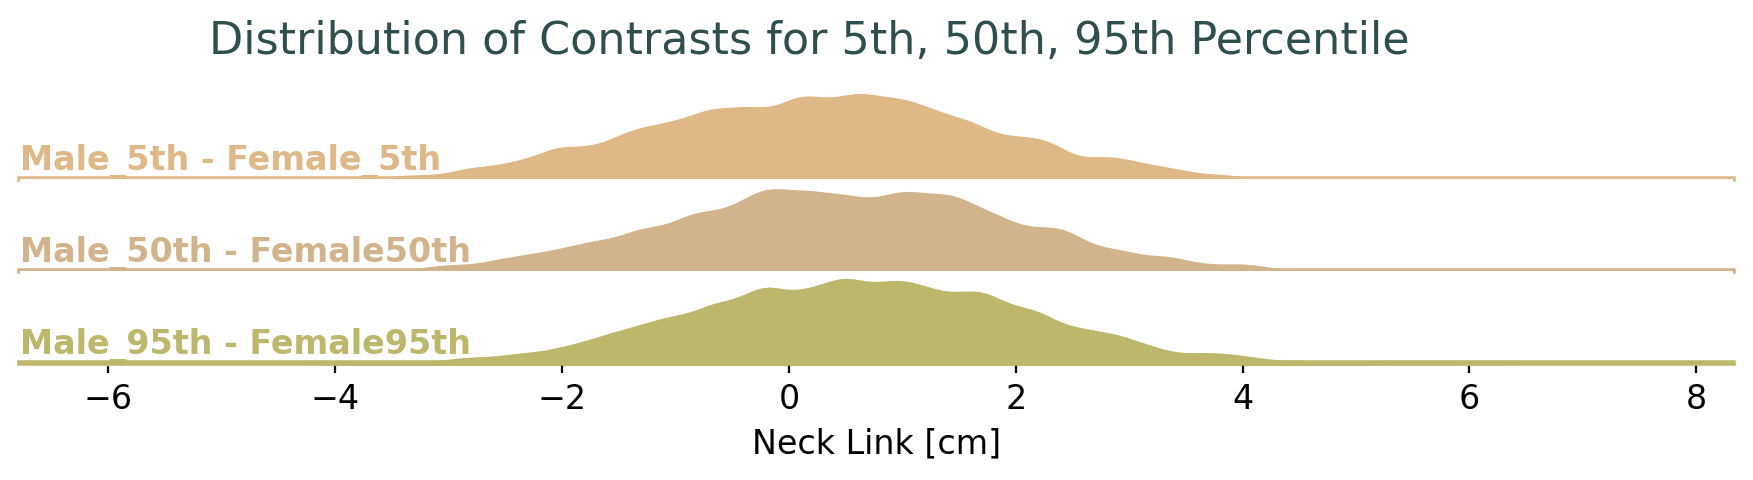

In [70]:
# Combine the data into a DataFrame
groups = ['Male_5th - Female_5th'] * 4000 + ['Male_50th - Female50th'] * 4000  + ['Male_95th - Female95th'] * 4000  
x = np.concatenate([(dummy5th_M - dummy5th_F)  , ( viva50M_M - viva50F_F ) ,( dummy95th_M - dummy95th_F)])

df = pd.DataFrame(dict(x=x, g=groups))

# Initialize the FacetGrid object

g = sns.FacetGrid(df, row="g", hue="g", aspect=12, height=.8, palette=["burlywood",  "tan", "darkkhaki"])
# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# # Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.001)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle("Distribution of Contrasts for 5th, 50th, 95th Percentile", fontsize=16, color="darkslategray")
# Set the x-axis label for the last subplot
g.set_axis_labels("Neck Link [cm]", "")
plt.show()